In [ ]:
import os
import json
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
%config InlineBackend.figure_format ='retina'

sns.set(font_scale=1.5)

sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
repos = ['Lend.it-user',
         'Lend.it-request',
         'Lend.it-rating',
         'Lend.it-gateway']

language = [['Lend.it-user', 'js'],
            ['Lend.it-request', 'py'],
            ['Lend.it-rating', 'py'],
            ['Lend.it-gateway', 'js']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]

In [ ]:
jsons = glob('data/fga-eps-mds-2020-2-data/lend-it/analytics-raw-data/*.json')

In [ ]:
jsons

In [ ]:
def read_json(json_path):

    with open(json_path) as json_file:
        json_obj = json.load(json_file)

    return json_obj

In [177]:
def create_base_component_df(json_list):

    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)

    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(\d+-\d+-\d+).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [178]:
base_component_df = create_base_component_df(jsons)

In [179]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
27,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
28,functions,30,NaN,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
29,security_rating,3.0,False,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
30,files,11,NaN,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
31,complexity,40,NaN,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
32,ncloc,214,NaN,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
33,coverage,0.0,False,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
34,reliability_rating,1.0,True,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
35,comment_lines_density,0.0,False,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
9,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-Lend.it-gateway-11-05-2021....,Lend.it-gateway,11-05-2021


In [ ]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

In [ ]:
def metric_per_file(json):

    file_json = []

    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)

    return file_json

In [ ]:
def generate_file_dataframe(metric_list, json, language_extension):

    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)

    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass

    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [ ]:
def generate_file_dataframe_per_release(metric_list, json, language_extension):

    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)

    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass

    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [183]:
def create_file_df(json_list):

    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        file_component_data = metric_per_file(file_component)
        file_name = os.path.basename(i)

        file_repository = file_name.split("-")[4] + "-" + file_name.split("-")[5]
        file_language = repos_language[f"{file_repository}"]

        file_component_df = generate_file_dataframe_per_release(metric_list,
                                                                file_component_data,
                                                                language_extension = file_language)
        file_component_df['filename'] = file_name

        df = df.append(file_component_df, ignore_index=True)

    # replace TeamName by yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(\d+-\d+-\d+).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [184]:
file_component_df = create_file_df(jsons)

In [185]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
37,src/app.js,7,11,0.0,0.0,0.0,40,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
38,src/utils/baseRequest.js,6,6,0.0,0.0,0.0,27,3.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
39,src/utils/endpoint.js,0,0,0.0,0.0,0.0,18,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
40,src/utils/mergeUser.js,6,8,0.0,0.0,0.0,22,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
41,src/microservices/Rating.js,0,1,0.0,0.0,0.0,3,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
42,src/microservices/Request.js,9,10,0.0,0.0,0.0,58,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
43,src/routes/request.routes.js,0,0,0.0,0.0,0.0,13,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
44,src/routes.js,0,0,0.0,0.0,0.0,7,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
45,src/server.js,0,1,0.0,0.0,0.0,7,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021
46,src/microservices/User.js,2,3,0.0,0.0,0.0,13,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-gateway-02-05-2021....,Lend.it-gateway,02-05-2021


In [186]:
# Create dataframe per repository

repository_dataframes = {}

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df

repository_dataframes.keys()

dict_keys(['Lend.it-user', 'Lend.it-request', 'Lend.it-rating', 'Lend.it-gateway'])

#### COMPLEXITY

In [187]:
def m1(df):

    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)

    return density_non_complex_files

#### COMMENTS

In [188]:
def m2(df):

    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)

    return density_comment_files

#### DUPLICATIONS

In [189]:
def m3(df):

    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)

    return duplication

In [190]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)

    return ncloc

In [191]:
# Calculating m1, m2 and m3 for each repository

def create_metrics_df(df):

    version_vec = df['version'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    repository_list = []
    version_list = []

    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'repository': repository_list,
                               'version': version_list})

    return metrics_df

In [192]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df

In [193]:
repository_dataframes["Lend.it-user"].head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
98,src/app.js,3,3,0.0,0.0,0.0,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-user-02-05-2021.json,Lend.it-user,02-05-2021
99,src/services/auth.js,1,1,0.0,0.0,0.0,7,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-user-02-05-2021.json,Lend.it-user,02-05-2021
100,src/middlewares/auth.js,2,6,0.0,0.0,0.0,23,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-user-02-05-2021.json,Lend.it-user,02-05-2021
101,src/config/database.js,0,0,0.0,0.0,NaN,44,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-user-02-05-2021.json,Lend.it-user,02-05-2021
102,src/db/index.js,3,3,0.0,0.0,0.0,18,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-user-02-05-2021.json,Lend.it-user,02-05-2021
103,src/routes.js,0,0,0.0,0.0,0.0,7,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-user-02-05-2021.json,Lend.it-user,02-05-2021
104,src/server.js,0,1,0.0,0.0,0.0,8,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-user-02-05-2021.json,Lend.it-user,02-05-2021
105,src/routes/session.routes.js,0,0,0.0,0.0,0.0,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-user-02-05-2021.json,Lend.it-user,02-05-2021
106,src/controllers/SessionController.js,1,3,0.0,0.0,0.0,22,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-user-02-05-2021.json,Lend.it-user,02-05-2021
107,src/models/User.js,1,1,0.0,0.0,0.0,26,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Lend.it-user-02-05-2021.json,Lend.it-user,02-05-2021


In [194]:
repository_metrics["Lend.it-user"]

,m1,m2,m3,repository,version
0,0.583333,0.0,1.0,Lend.it-user,02-05-2021
1,0.583333,0.0,1.0,Lend.it-user,11-05-2021
2,0.642857,0.0,1.0,Lend.it-user,13-04-2021
3,0.642857,0.0,1.0,Lend.it-user,15-04-2021
4,0.642857,0.0,1.0,Lend.it-user,25-04-2021


In [195]:
repository_metrics["Lend.it-request"]

,m1,m2,m3,repository,version
0,0.769231,0.230769,1.0,Lend.it-request,02-05-2021
1,0.769231,0.230769,1.0,Lend.it-request,11-05-2021
2,0.800000,0.200000,1.0,Lend.it-request,13-04-2021
3,0.800000,0.200000,1.0,Lend.it-request,15-04-2021
4,0.800000,0.200000,1.0,Lend.it-request,25-04-2021


In [196]:
repository_metrics["Lend.it-rating"]

,m1,m2,m3,repository,version
0,0.750000,0.250000,1.0,Lend.it-rating,02-05-2021
1,0.750000,0.250000,1.0,Lend.it-rating,11-05-2021
2,0.727273,0.272727,1.0,Lend.it-rating,13-04-2021
3,0.727273,0.272727,1.0,Lend.it-rating,15-04-2021
4,0.769231,0.230769,1.0,Lend.it-rating,25-04-2021


In [197]:
repository_metrics["Lend.it-gateway"]

,m1,m2,m3,repository,version
0,0.454545,0.0,1.0,Lend.it-gateway,02-05-2021
1,0.454545,0.0,1.0,Lend.it-gateway,11-05-2021
2,0.454545,0.0,1.0,Lend.it-gateway,13-04-2021
3,0.500000,0.0,1.0,Lend.it-gateway,15-04-2021
4,0.538462,0.0,1.0,Lend.it-gateway,25-04-2021


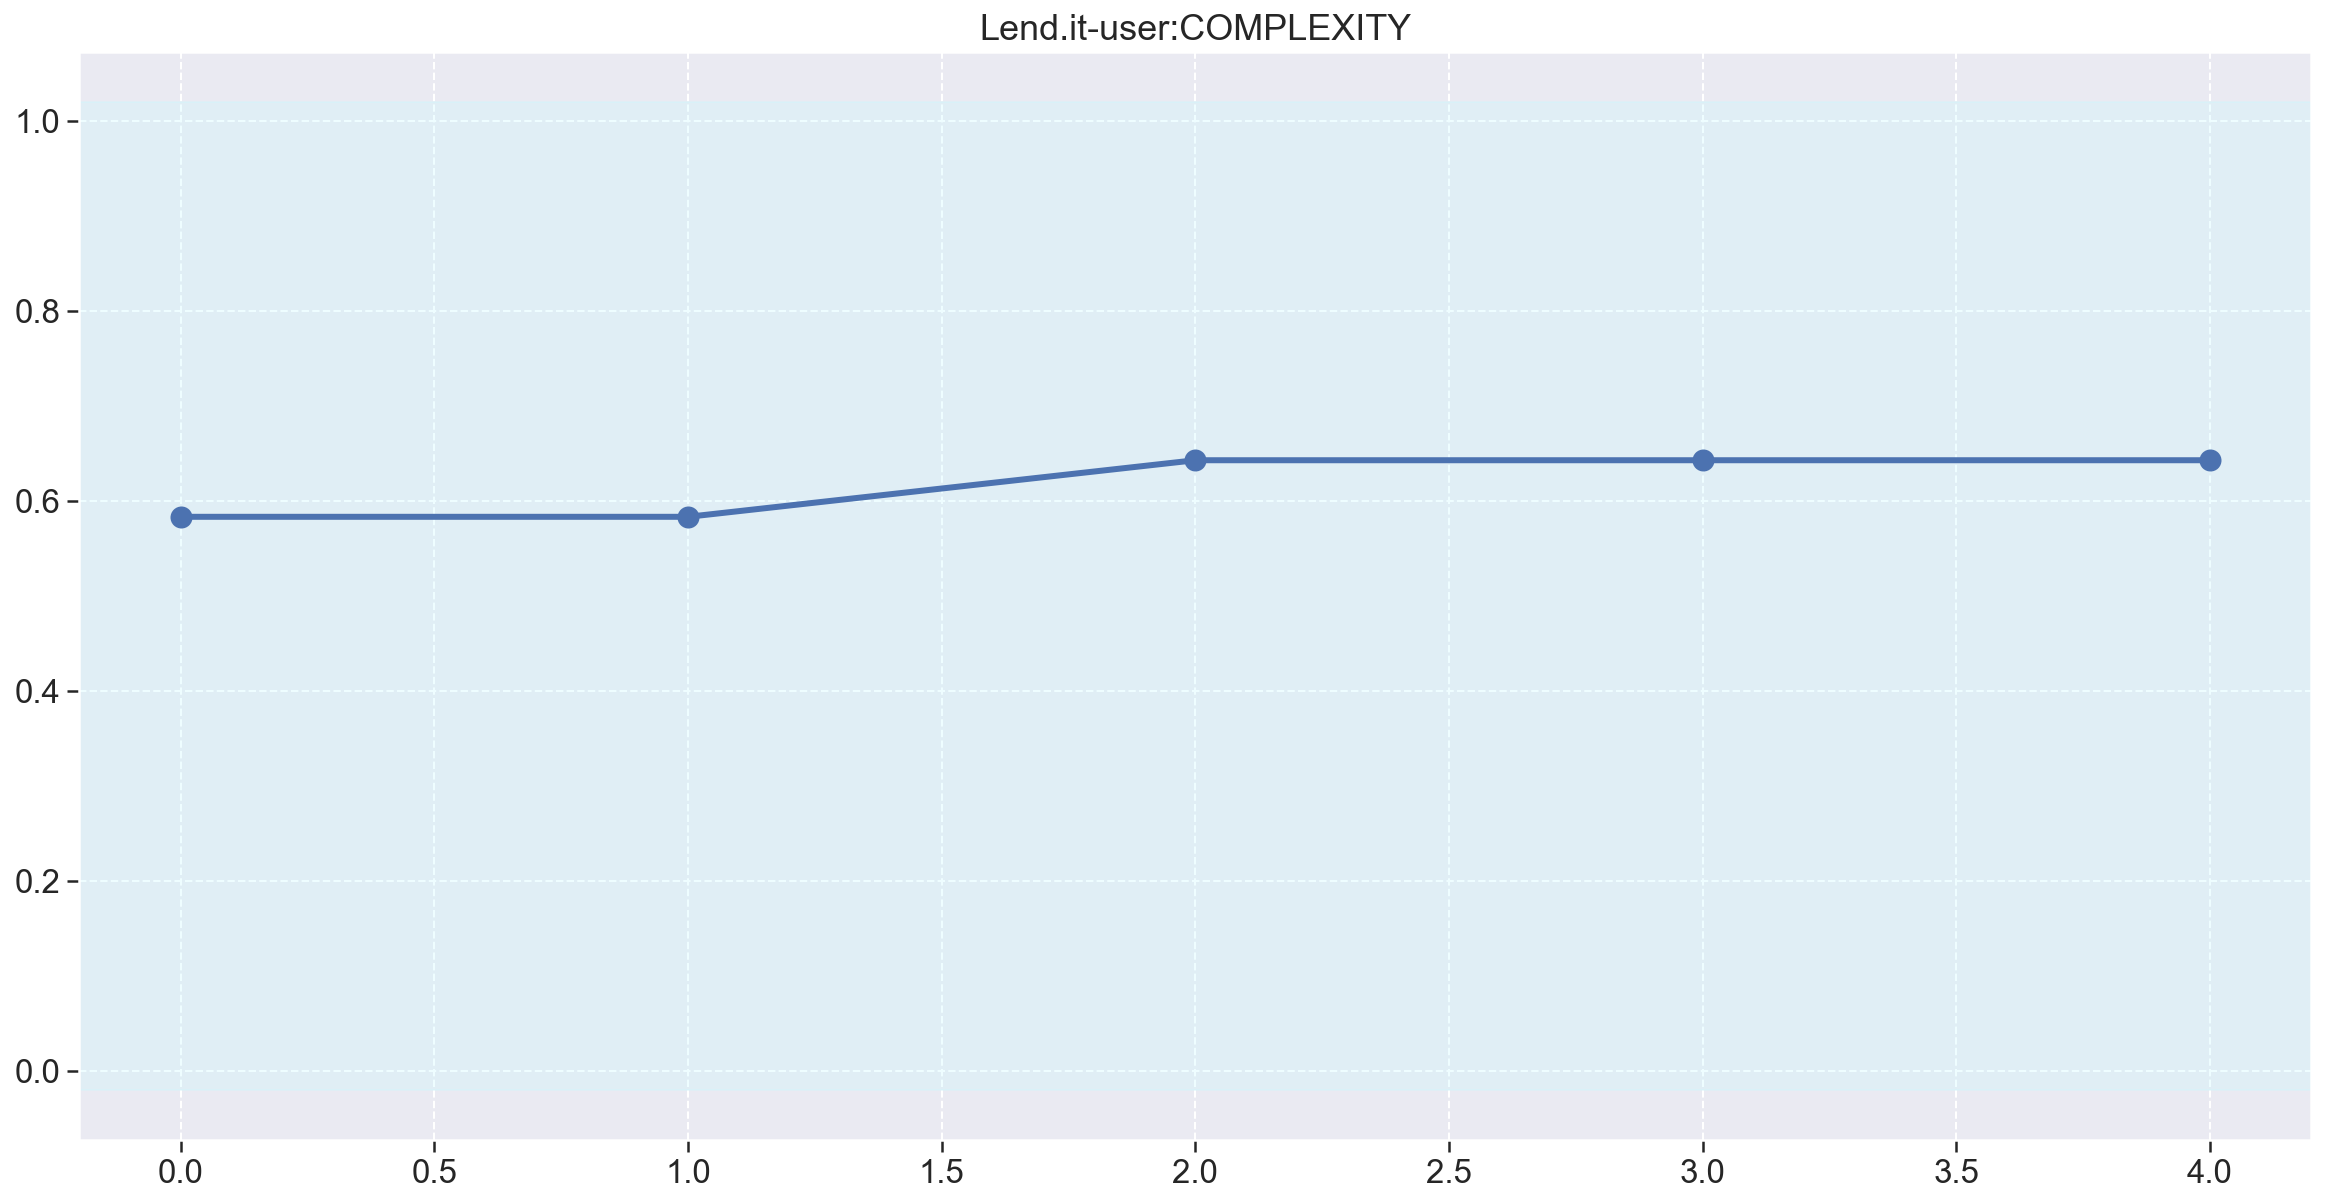

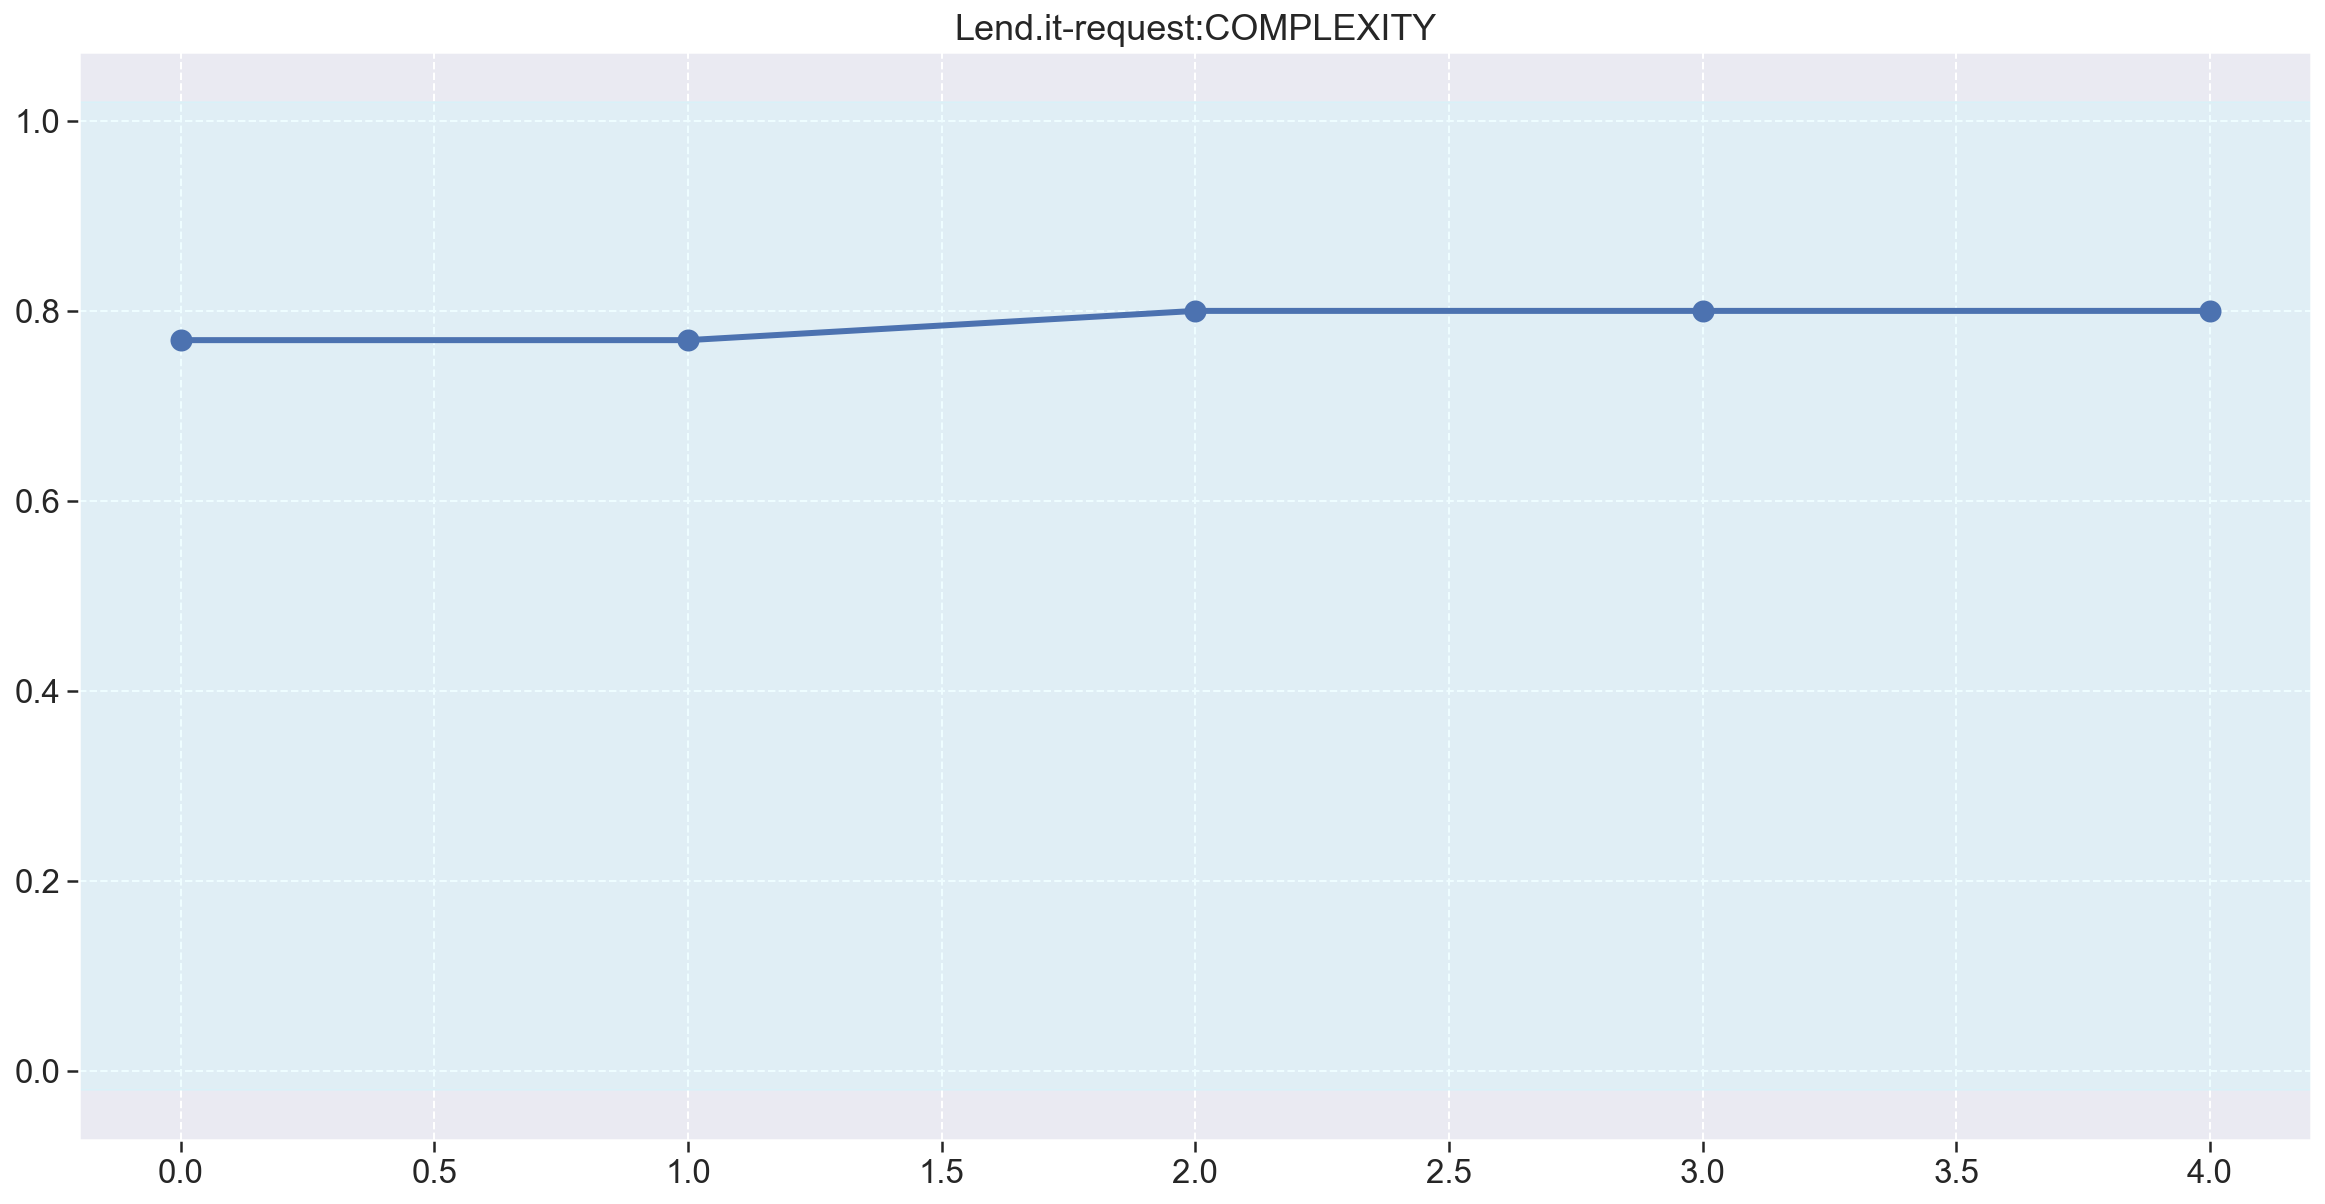

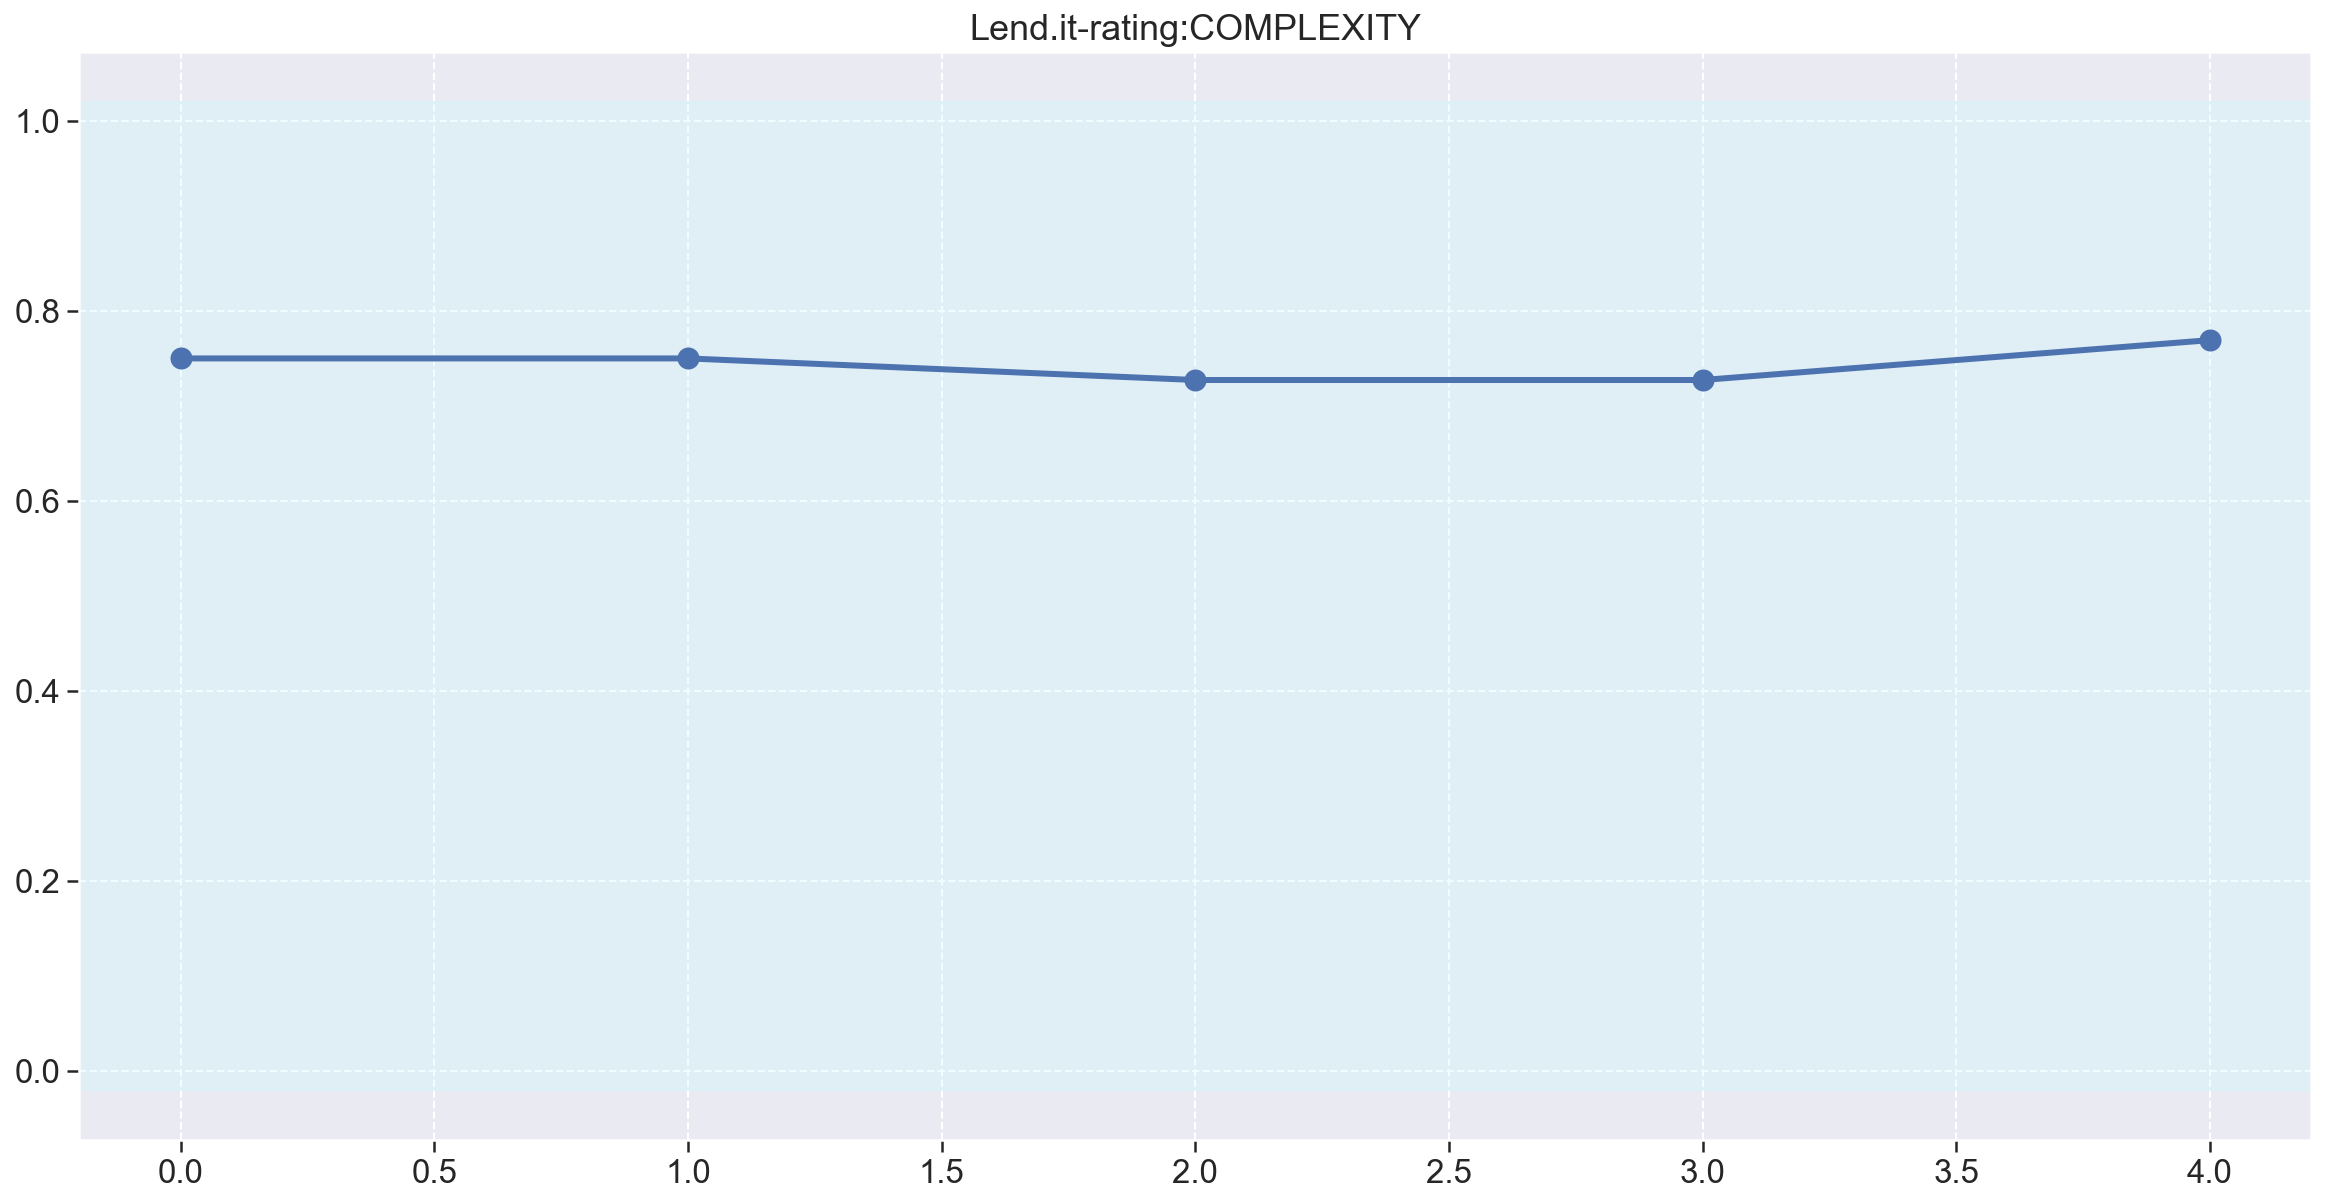

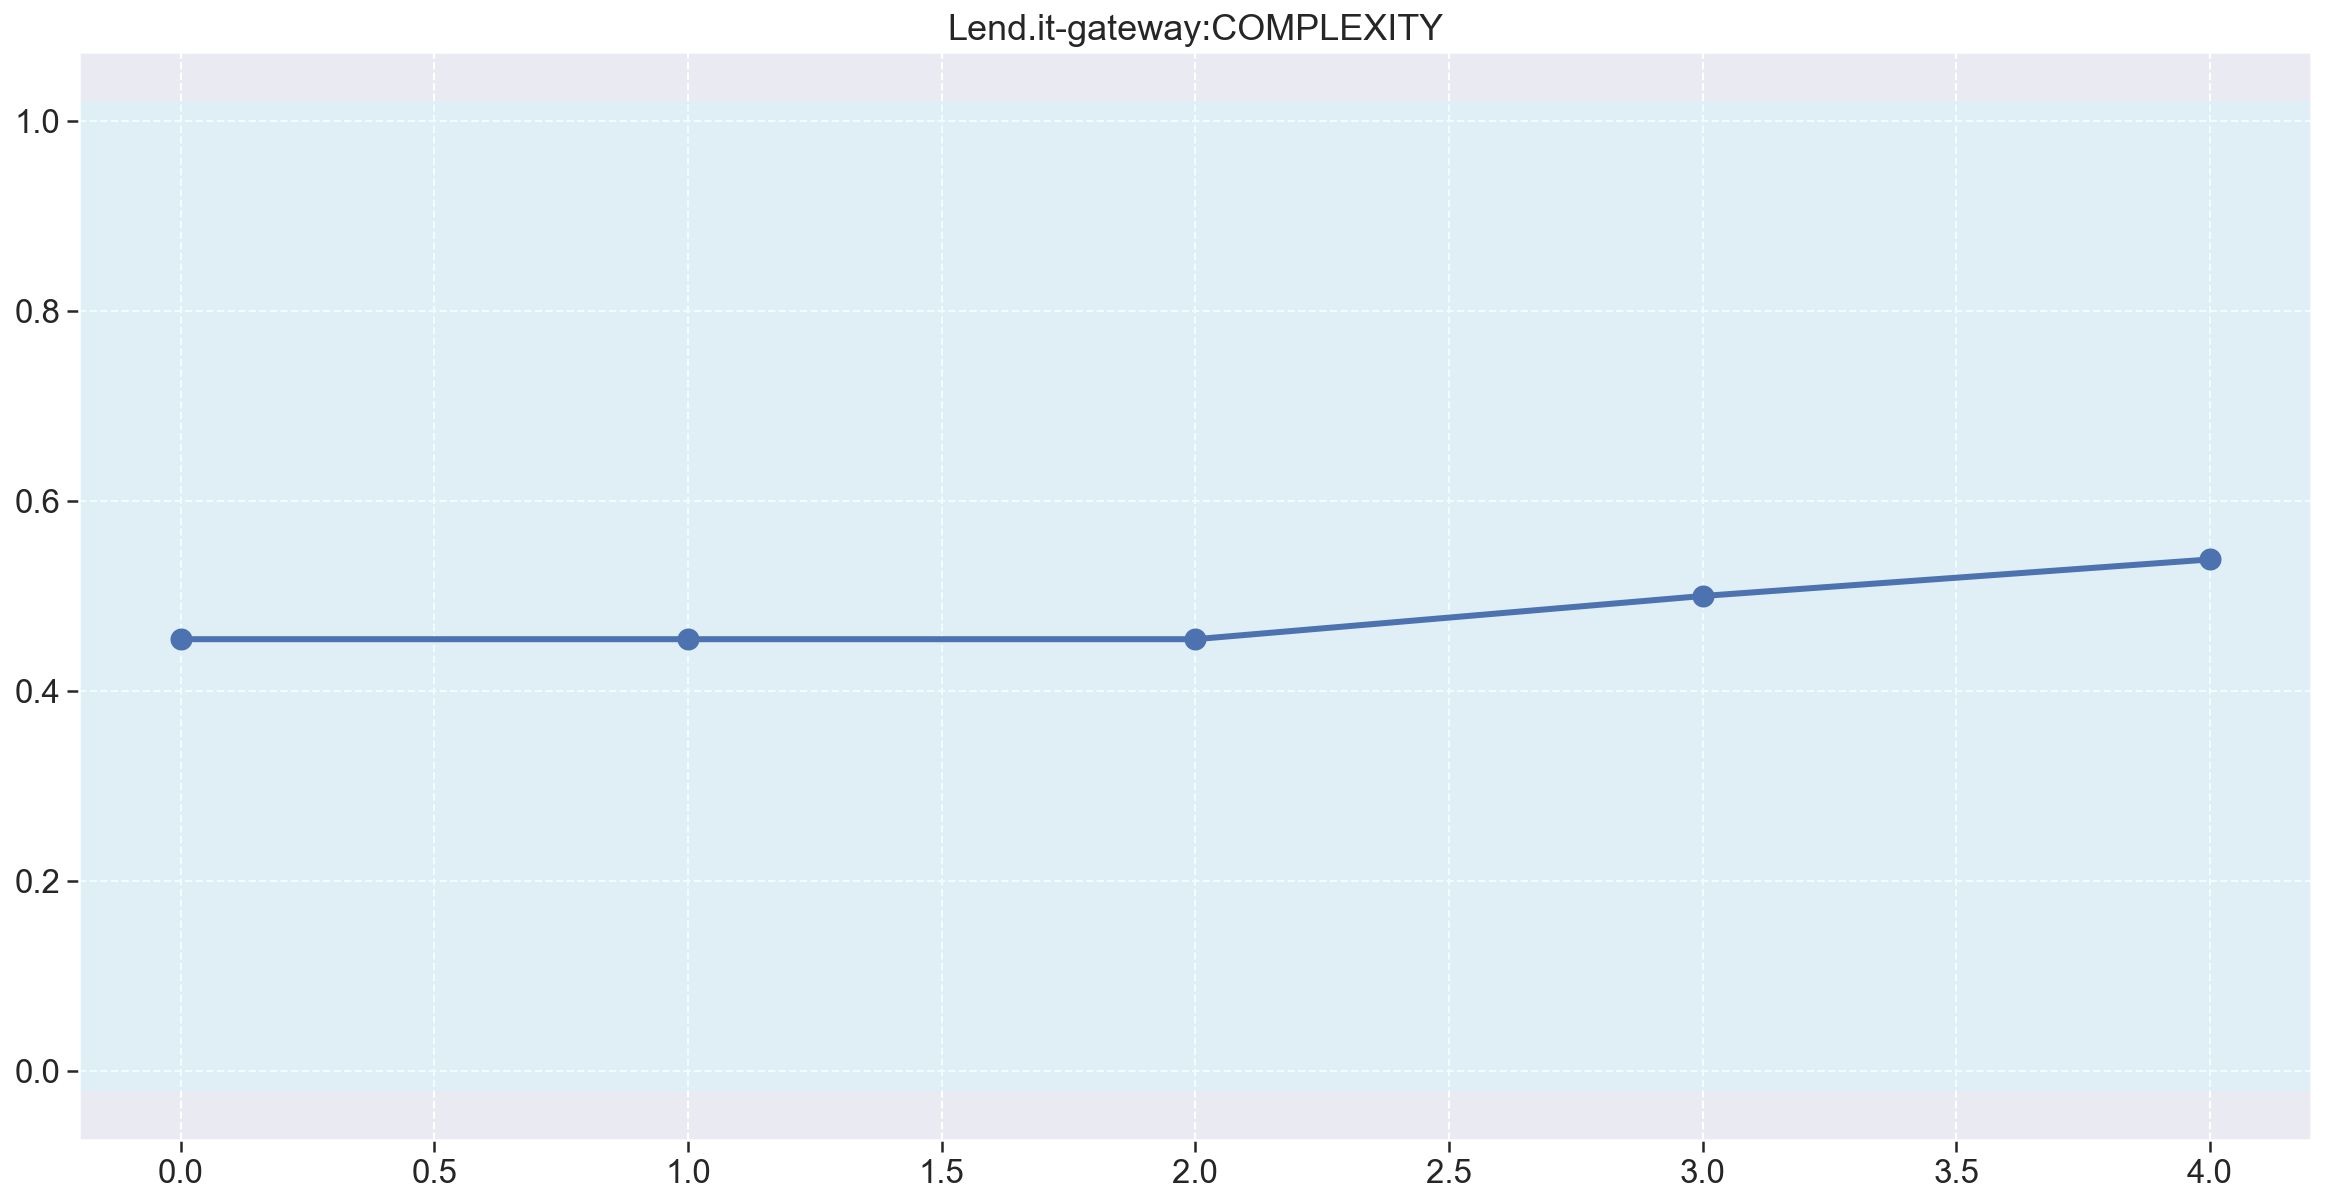

In [198]:
for repository, metrics_df in repository_metrics.items():
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMPLEXITY")
    plt.plot(metrics_df['m1'], linewidth=3, marker='o', markersize=10)
    # Background color
    plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

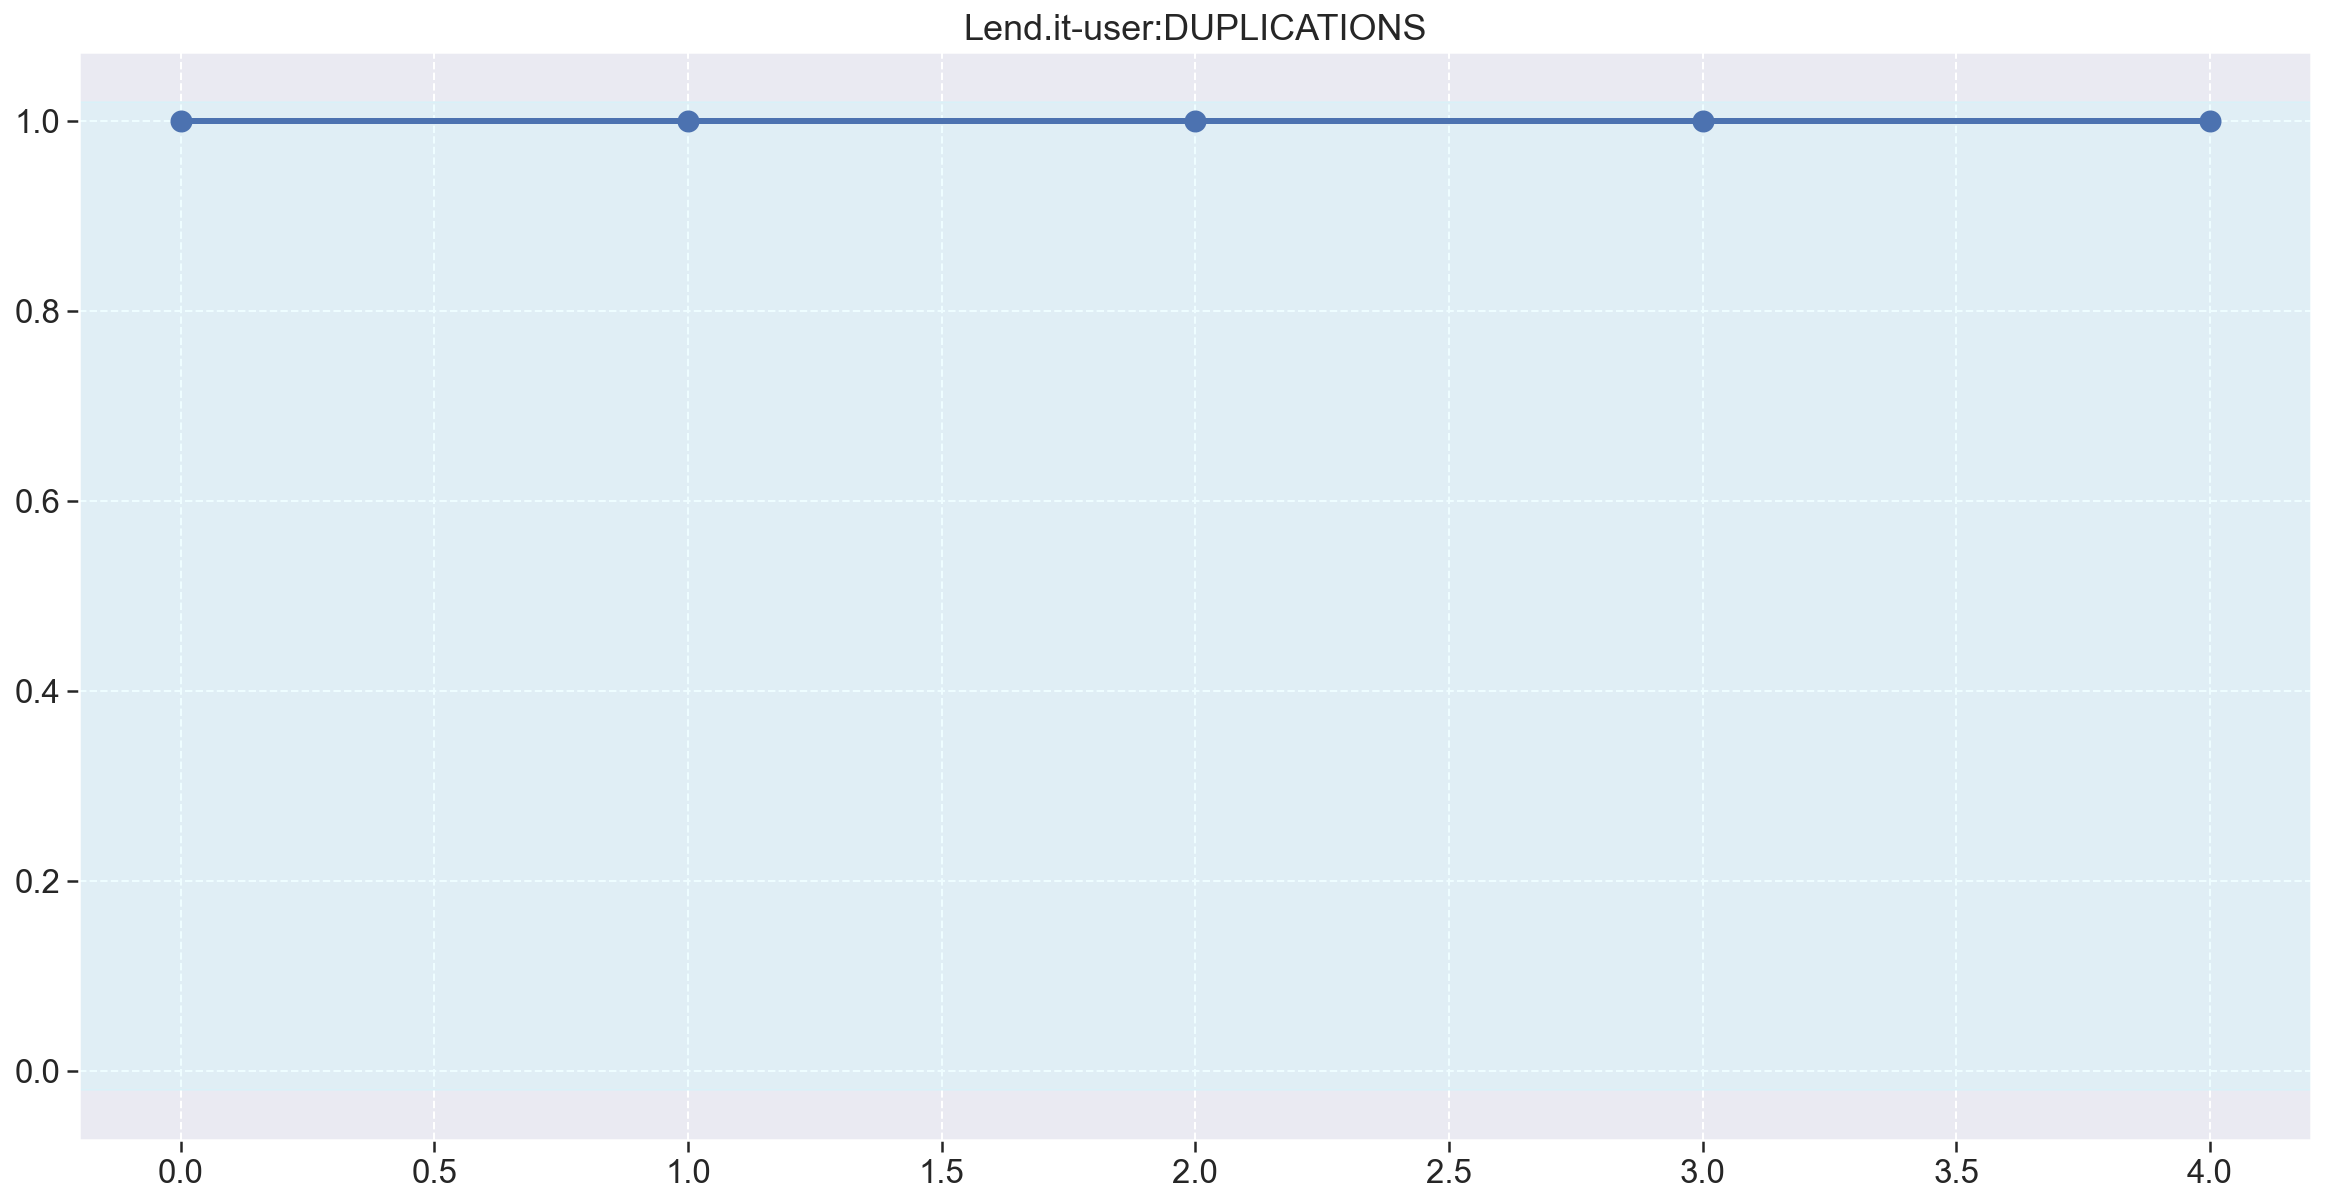

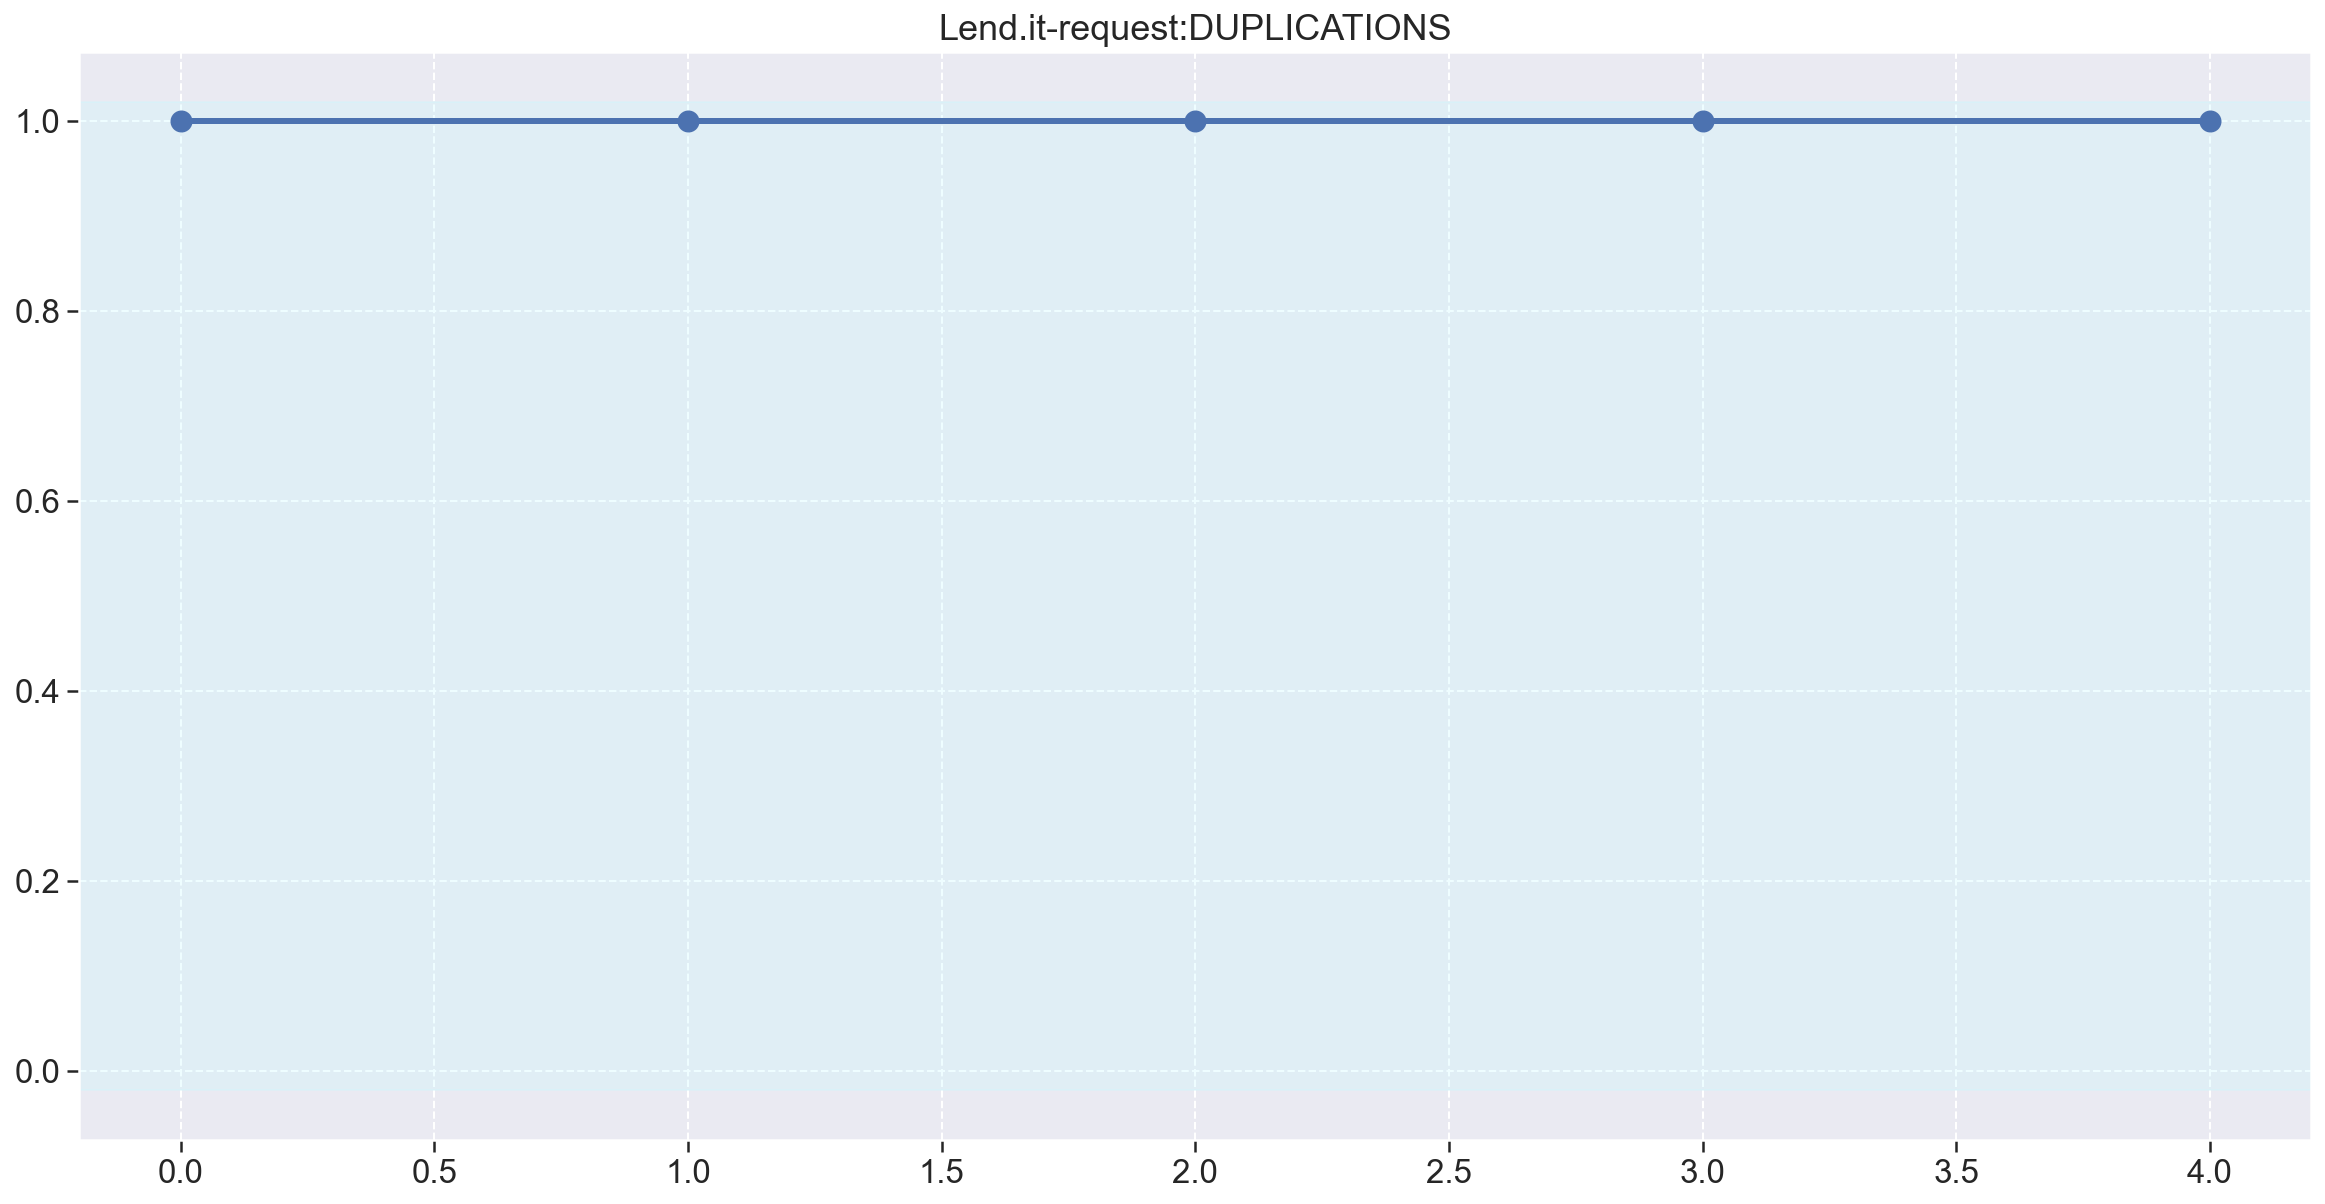

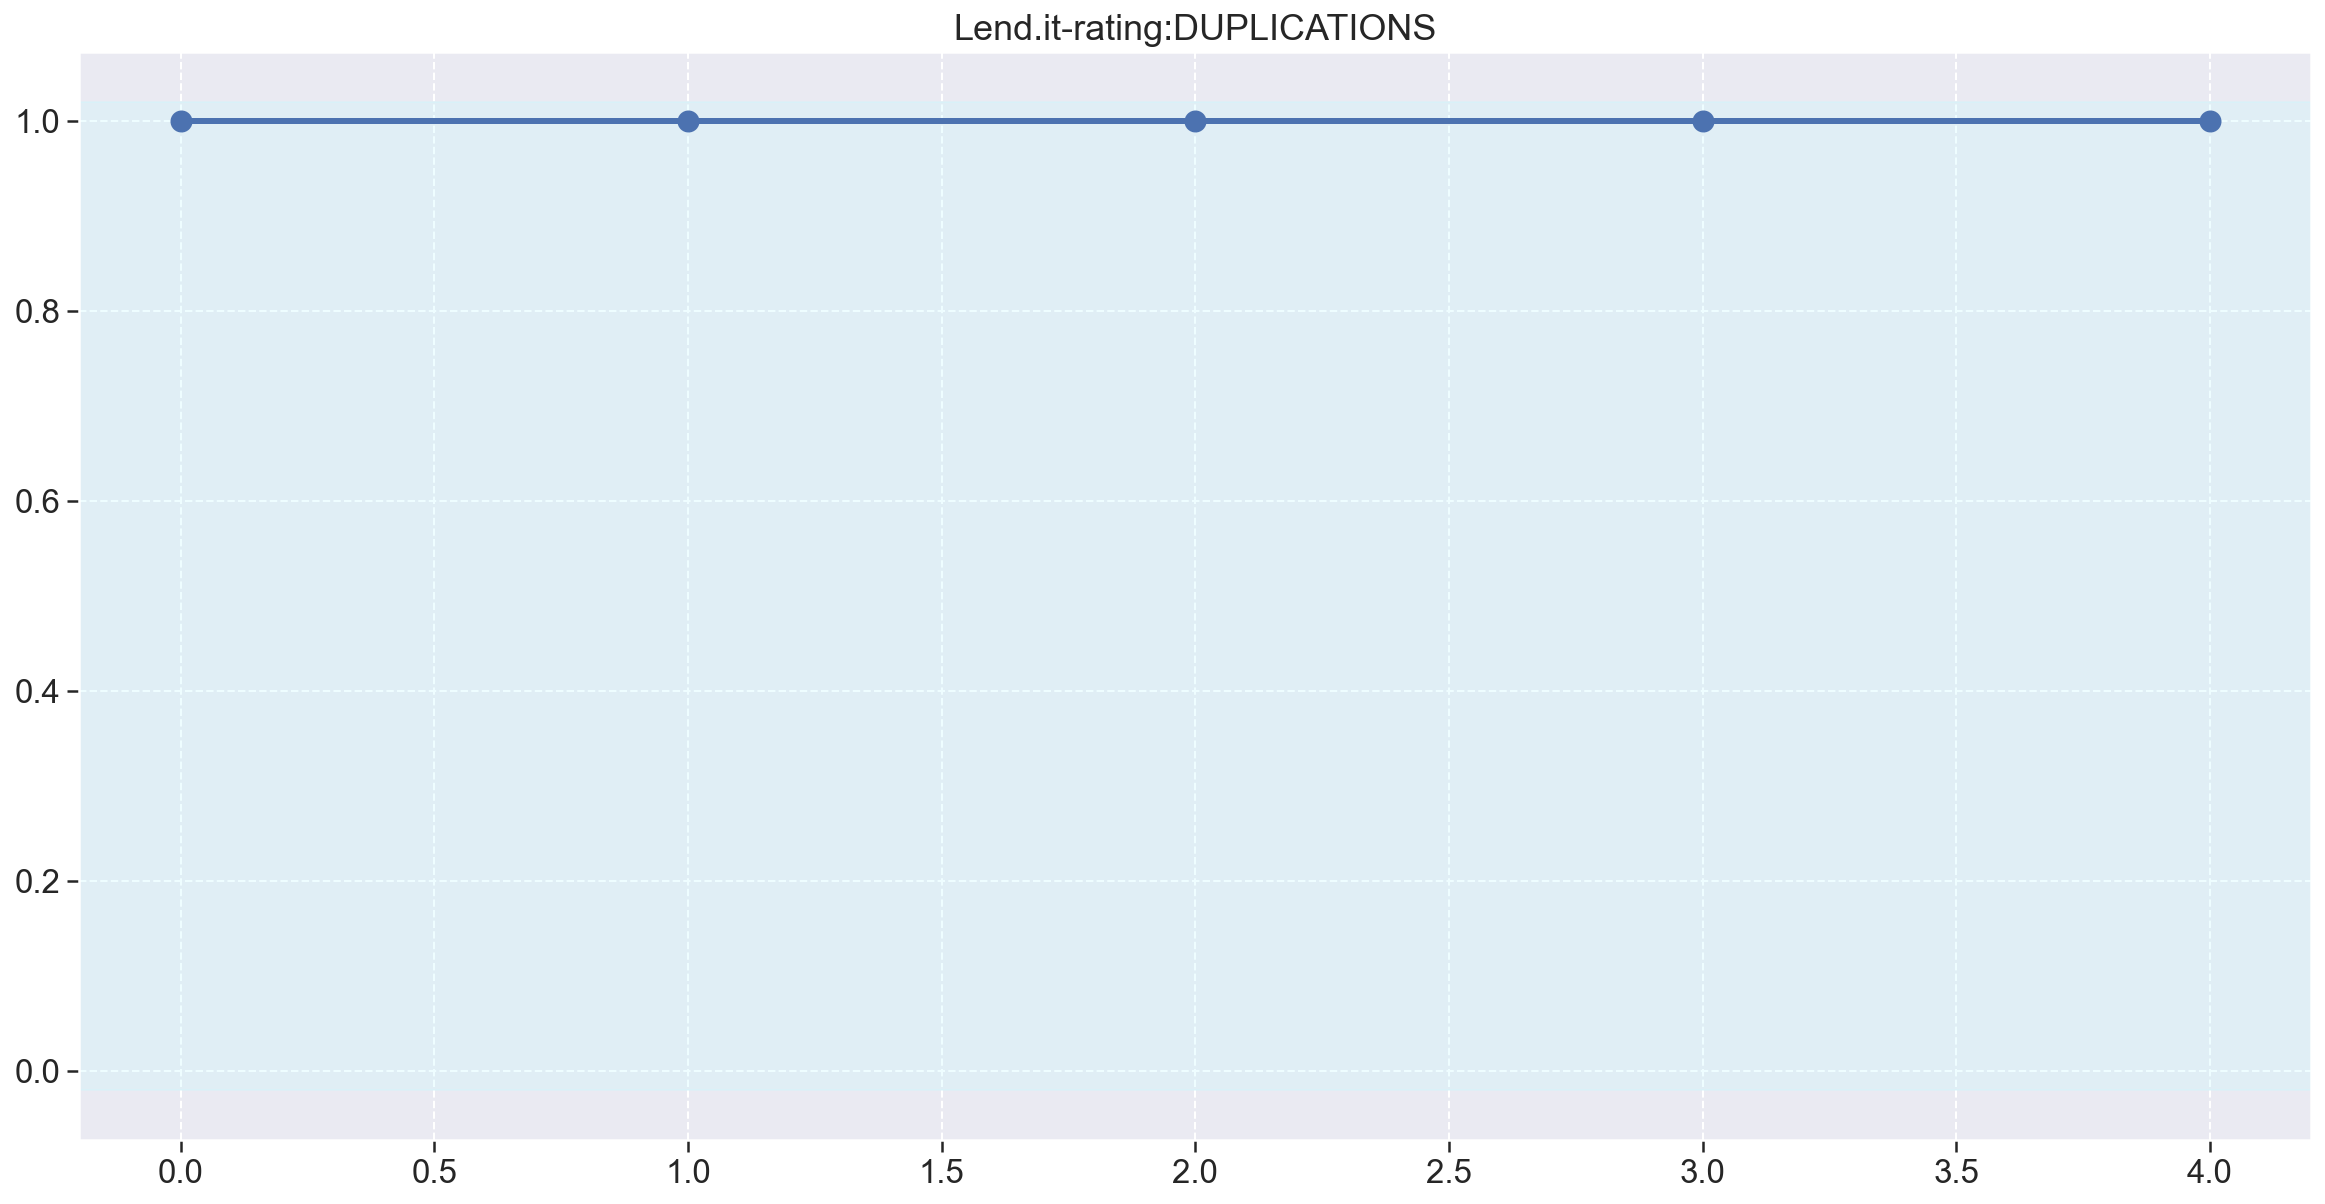

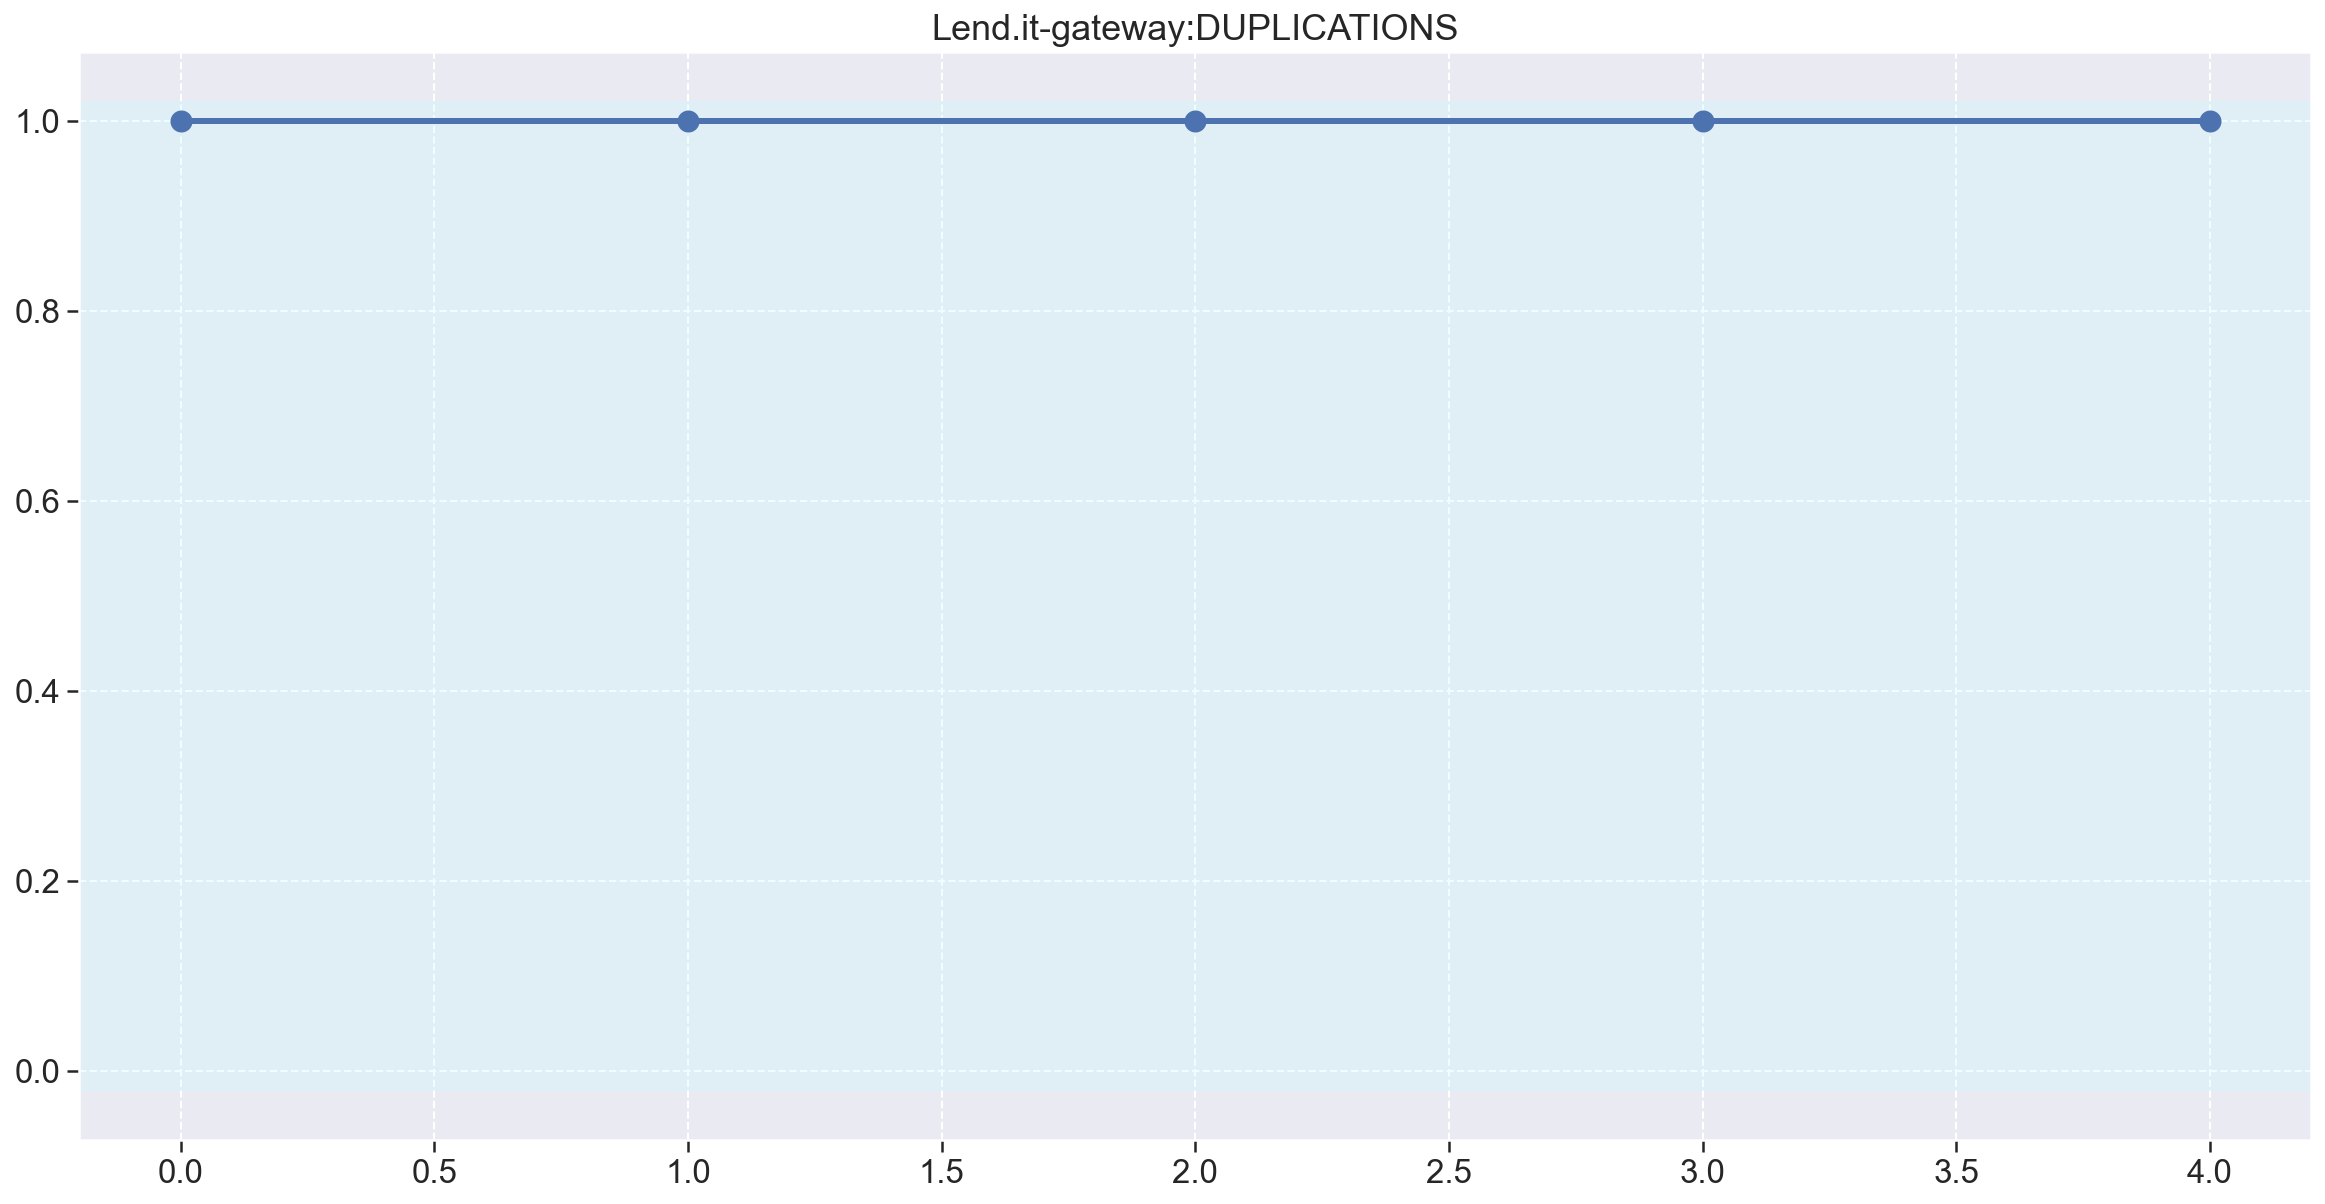

In [199]:
for repository, metrics_df in repository_metrics.items():
    fig = plt.figure(figsize=(20, 10))
    # Background color
    plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)
    plt.title(f"{repository}:DUPLICATIONS")
    plt.plot(metrics_df['m3'], linewidth=3, marker='o', markersize=10)

## Repository: User

#### All metrics

(-0.02, 1.02)

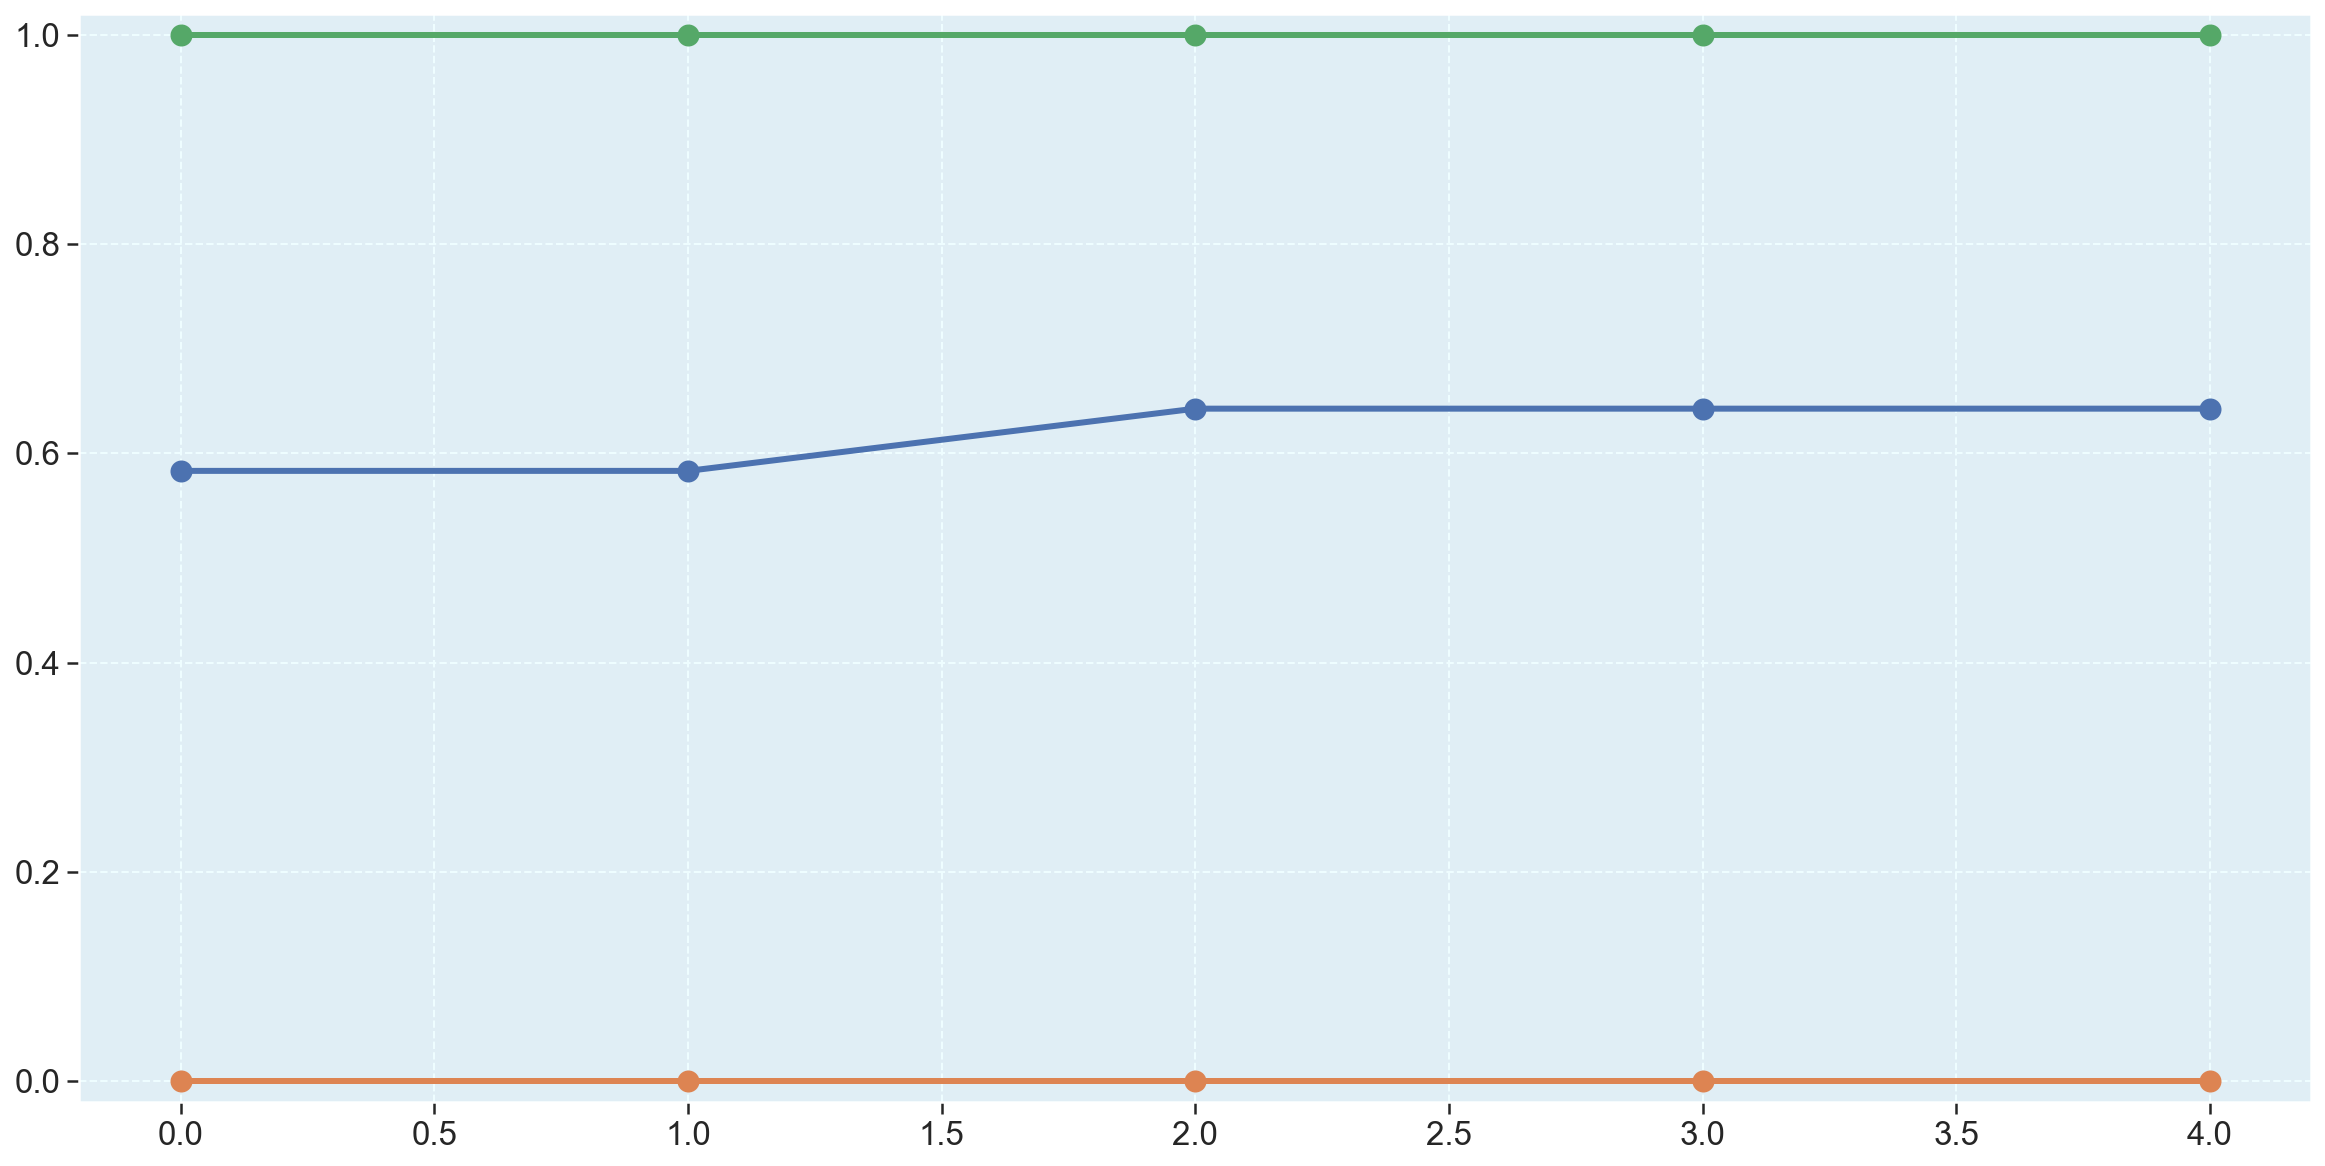

In [200]:
fig = plt.figure(figsize=(20, 10))

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.plot(repository_metrics["Lend.it-user"]['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repository_metrics["Lend.it-user"]['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repository_metrics["Lend.it-user"]['m3'], linewidth=3, marker='o', markersize=10)

plt.ylim(-.02,1.02)

## Repository: Request

#### All metrics

(-0.02, 1.02)

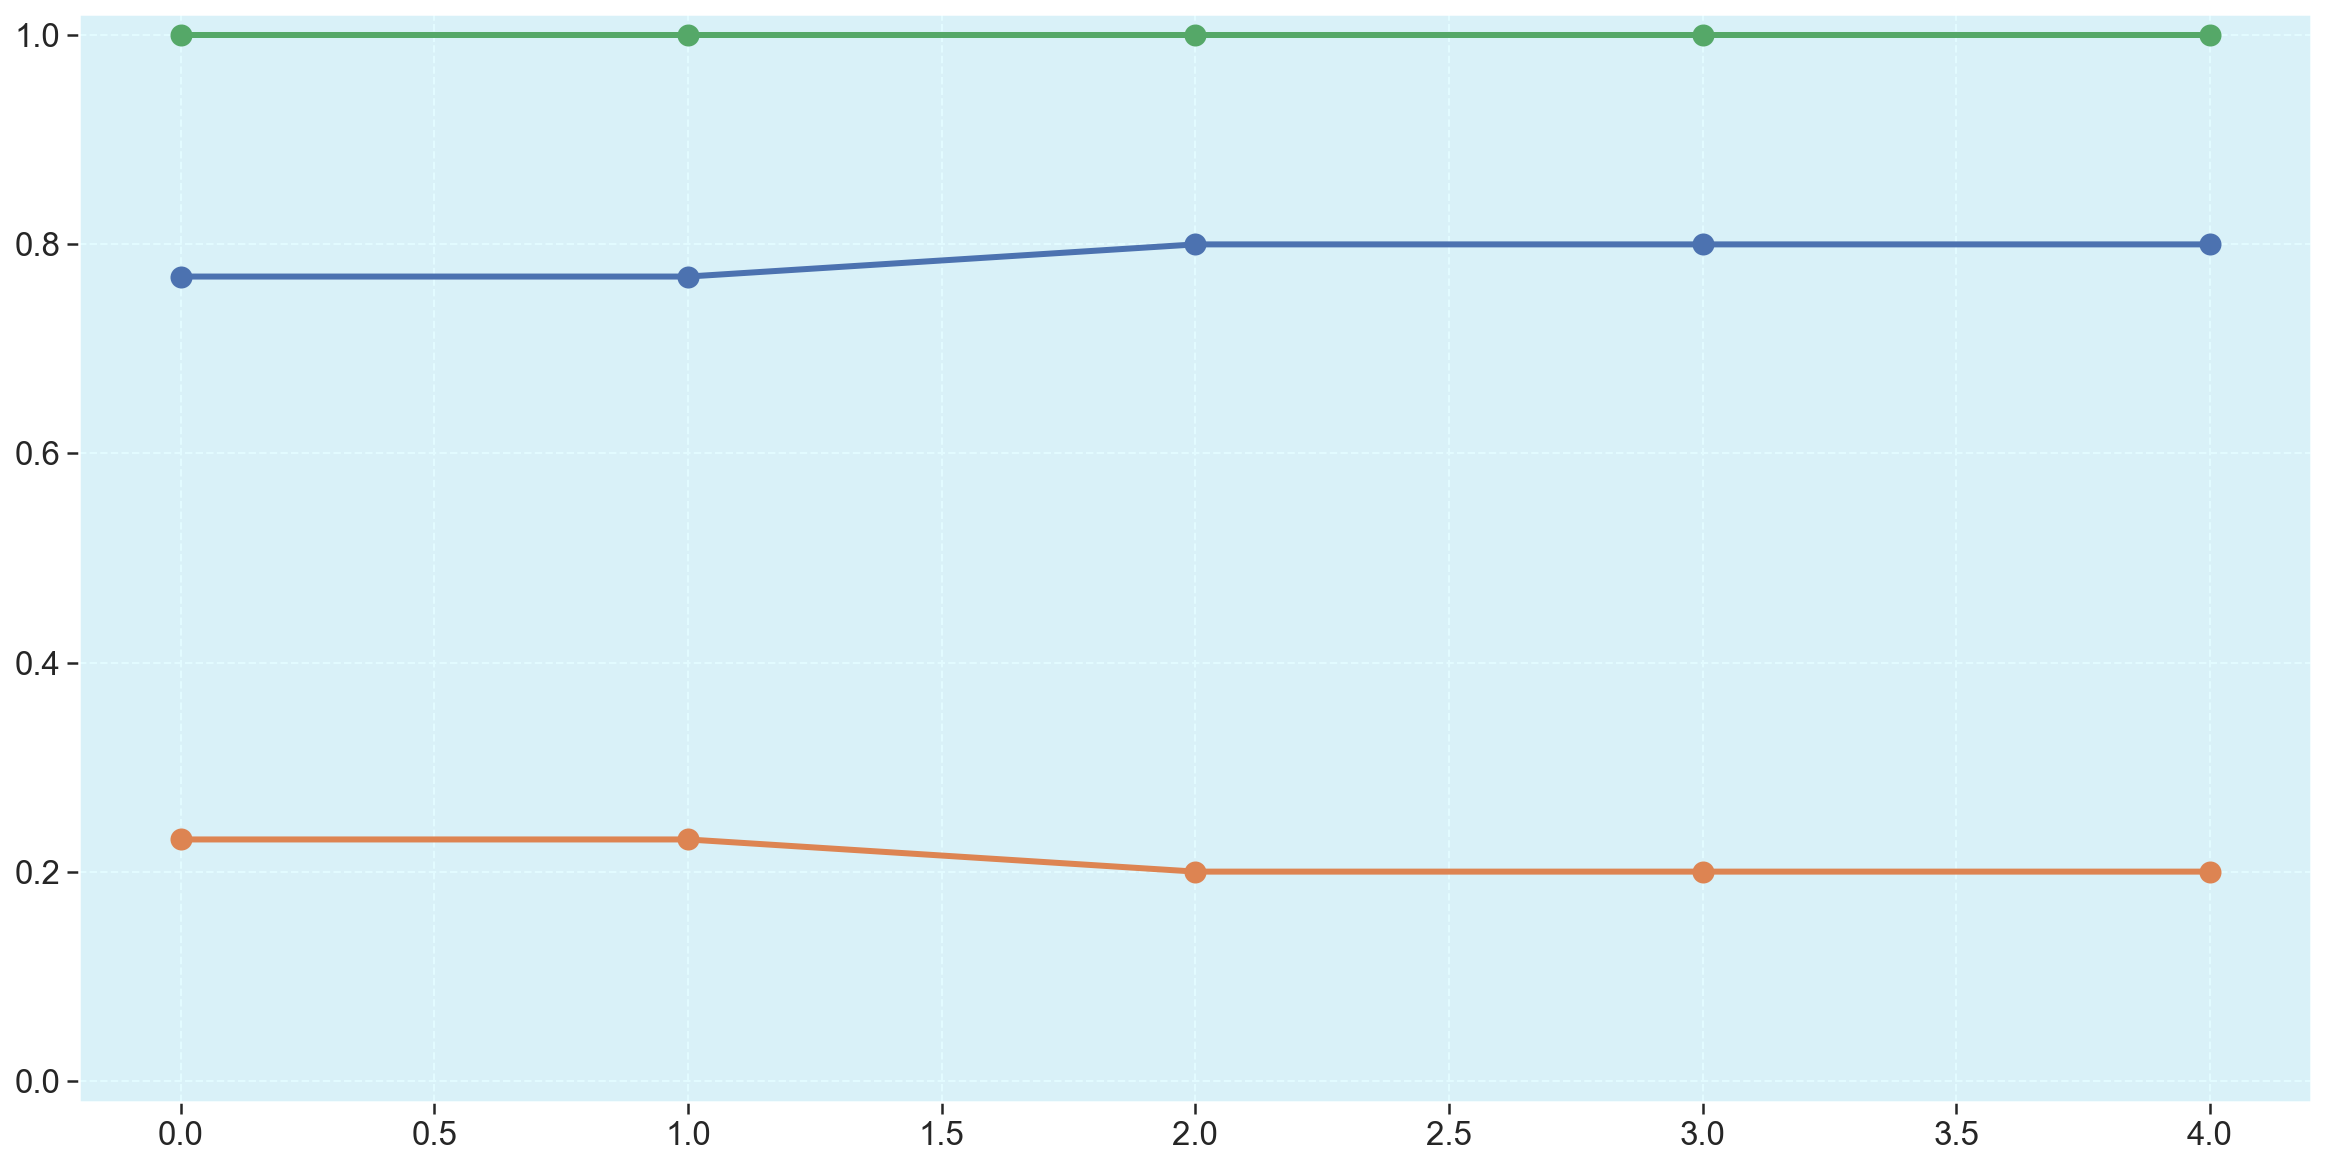

In [202]:
ratingfig = plt.figure(figsize=(20, 10))

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.plot(repository_metrics["Lend.it-request"]['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repository_metrics["Lend.it-request"]['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repository_metrics["Lend.it-request"]['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(-.02,1.02)

## Repository: Rating

#### All metrics

(-0.02, 1.02)

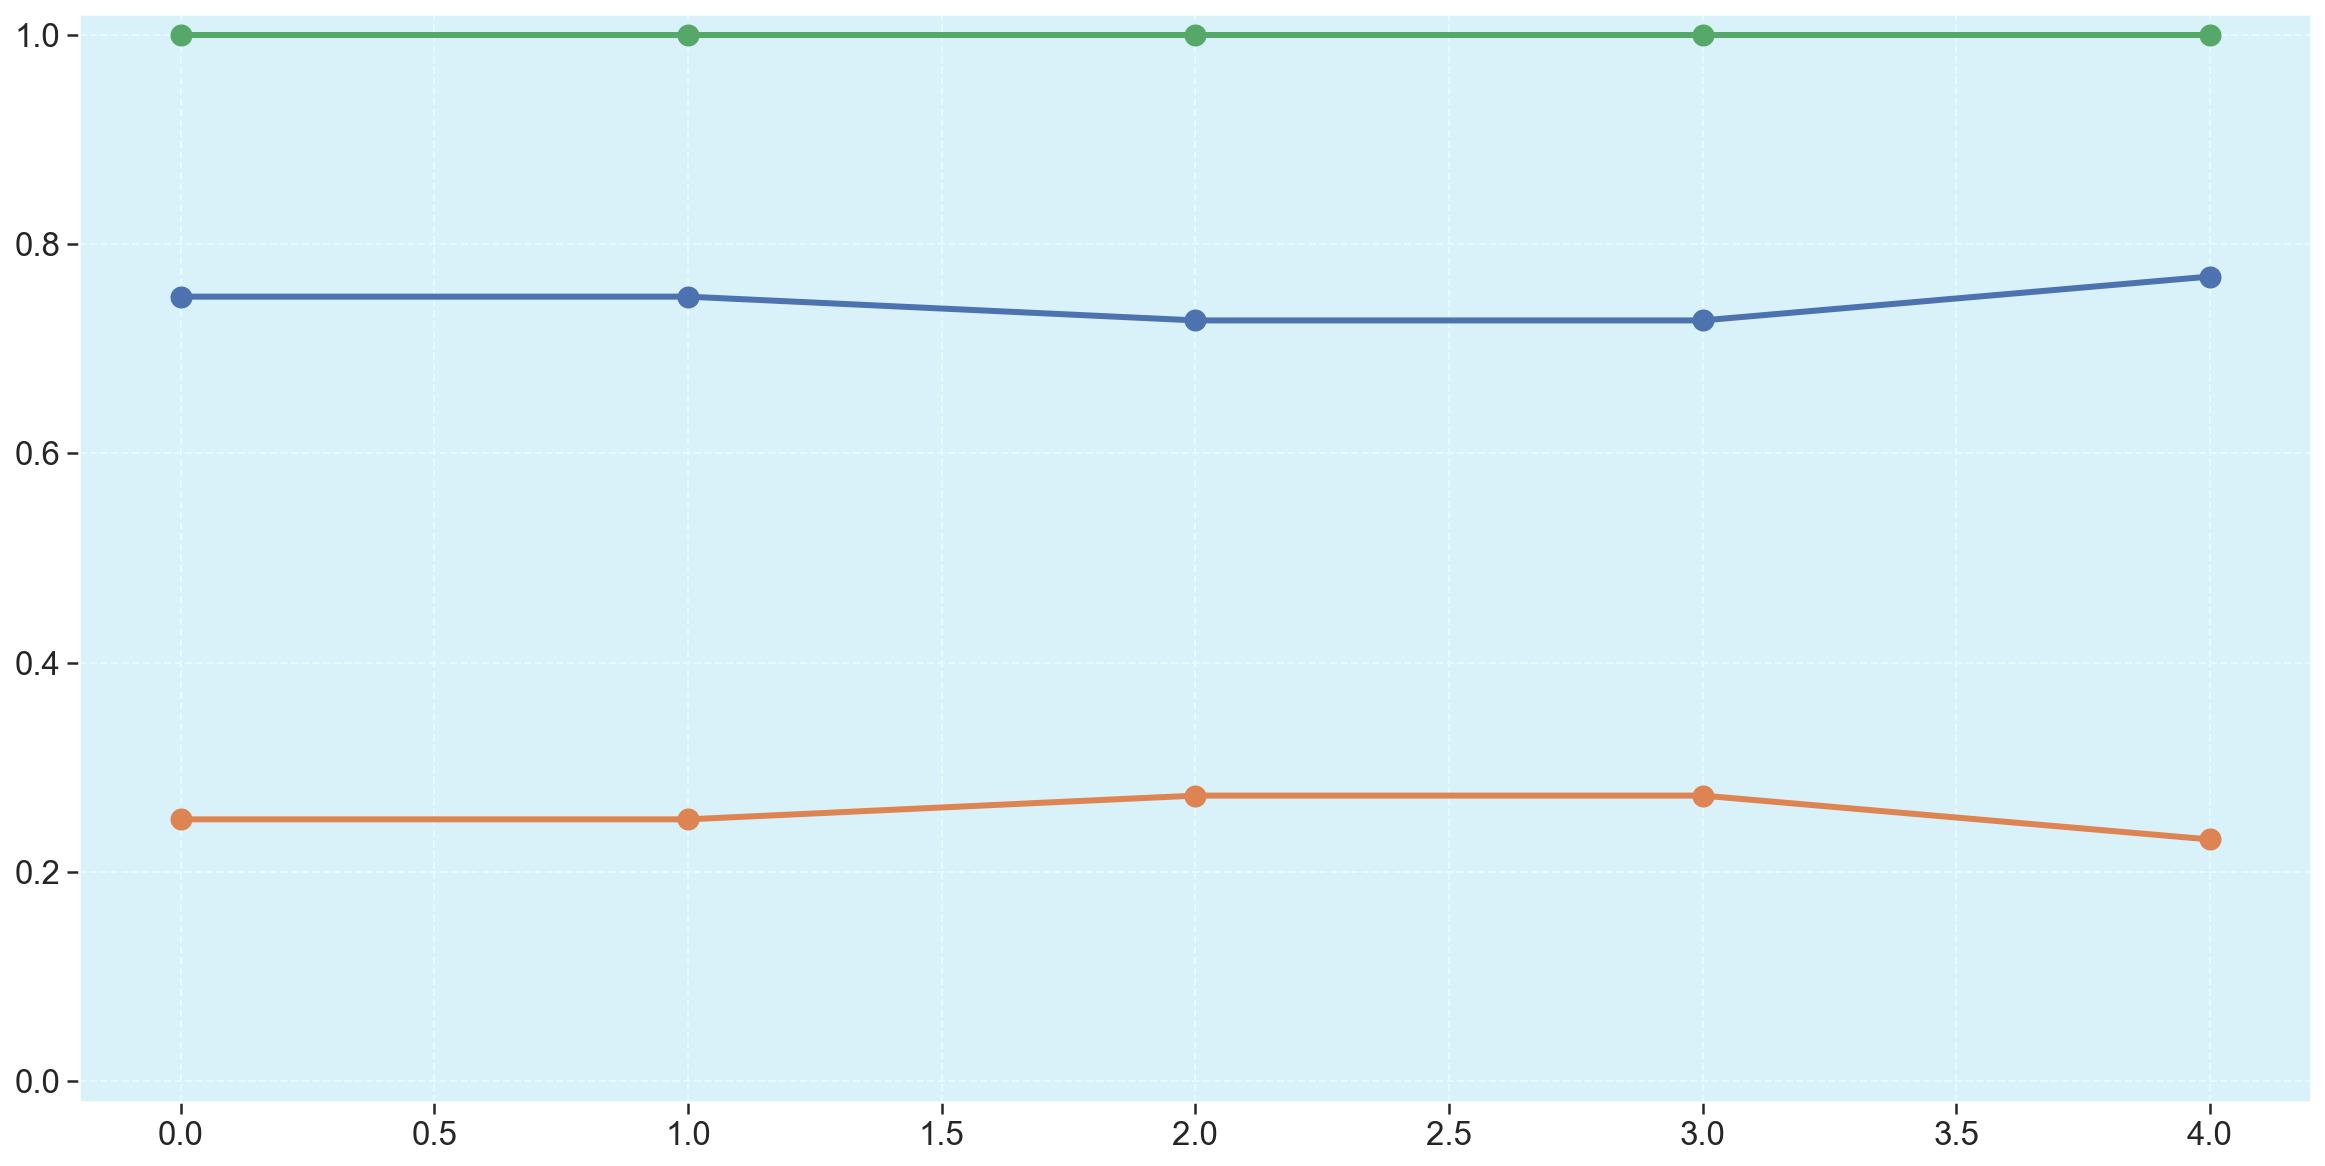

In [203]:
fig = plt.figure(figsize=(20, 10))

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.plot(repository_metrics["Lend.it-rating"]['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repository_metrics["Lend.it-rating"]['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repository_metrics["Lend.it-rating"]['m3'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.ylim(-.02,1.02)

## Repository: Gateway

(-0.02, 1.02)

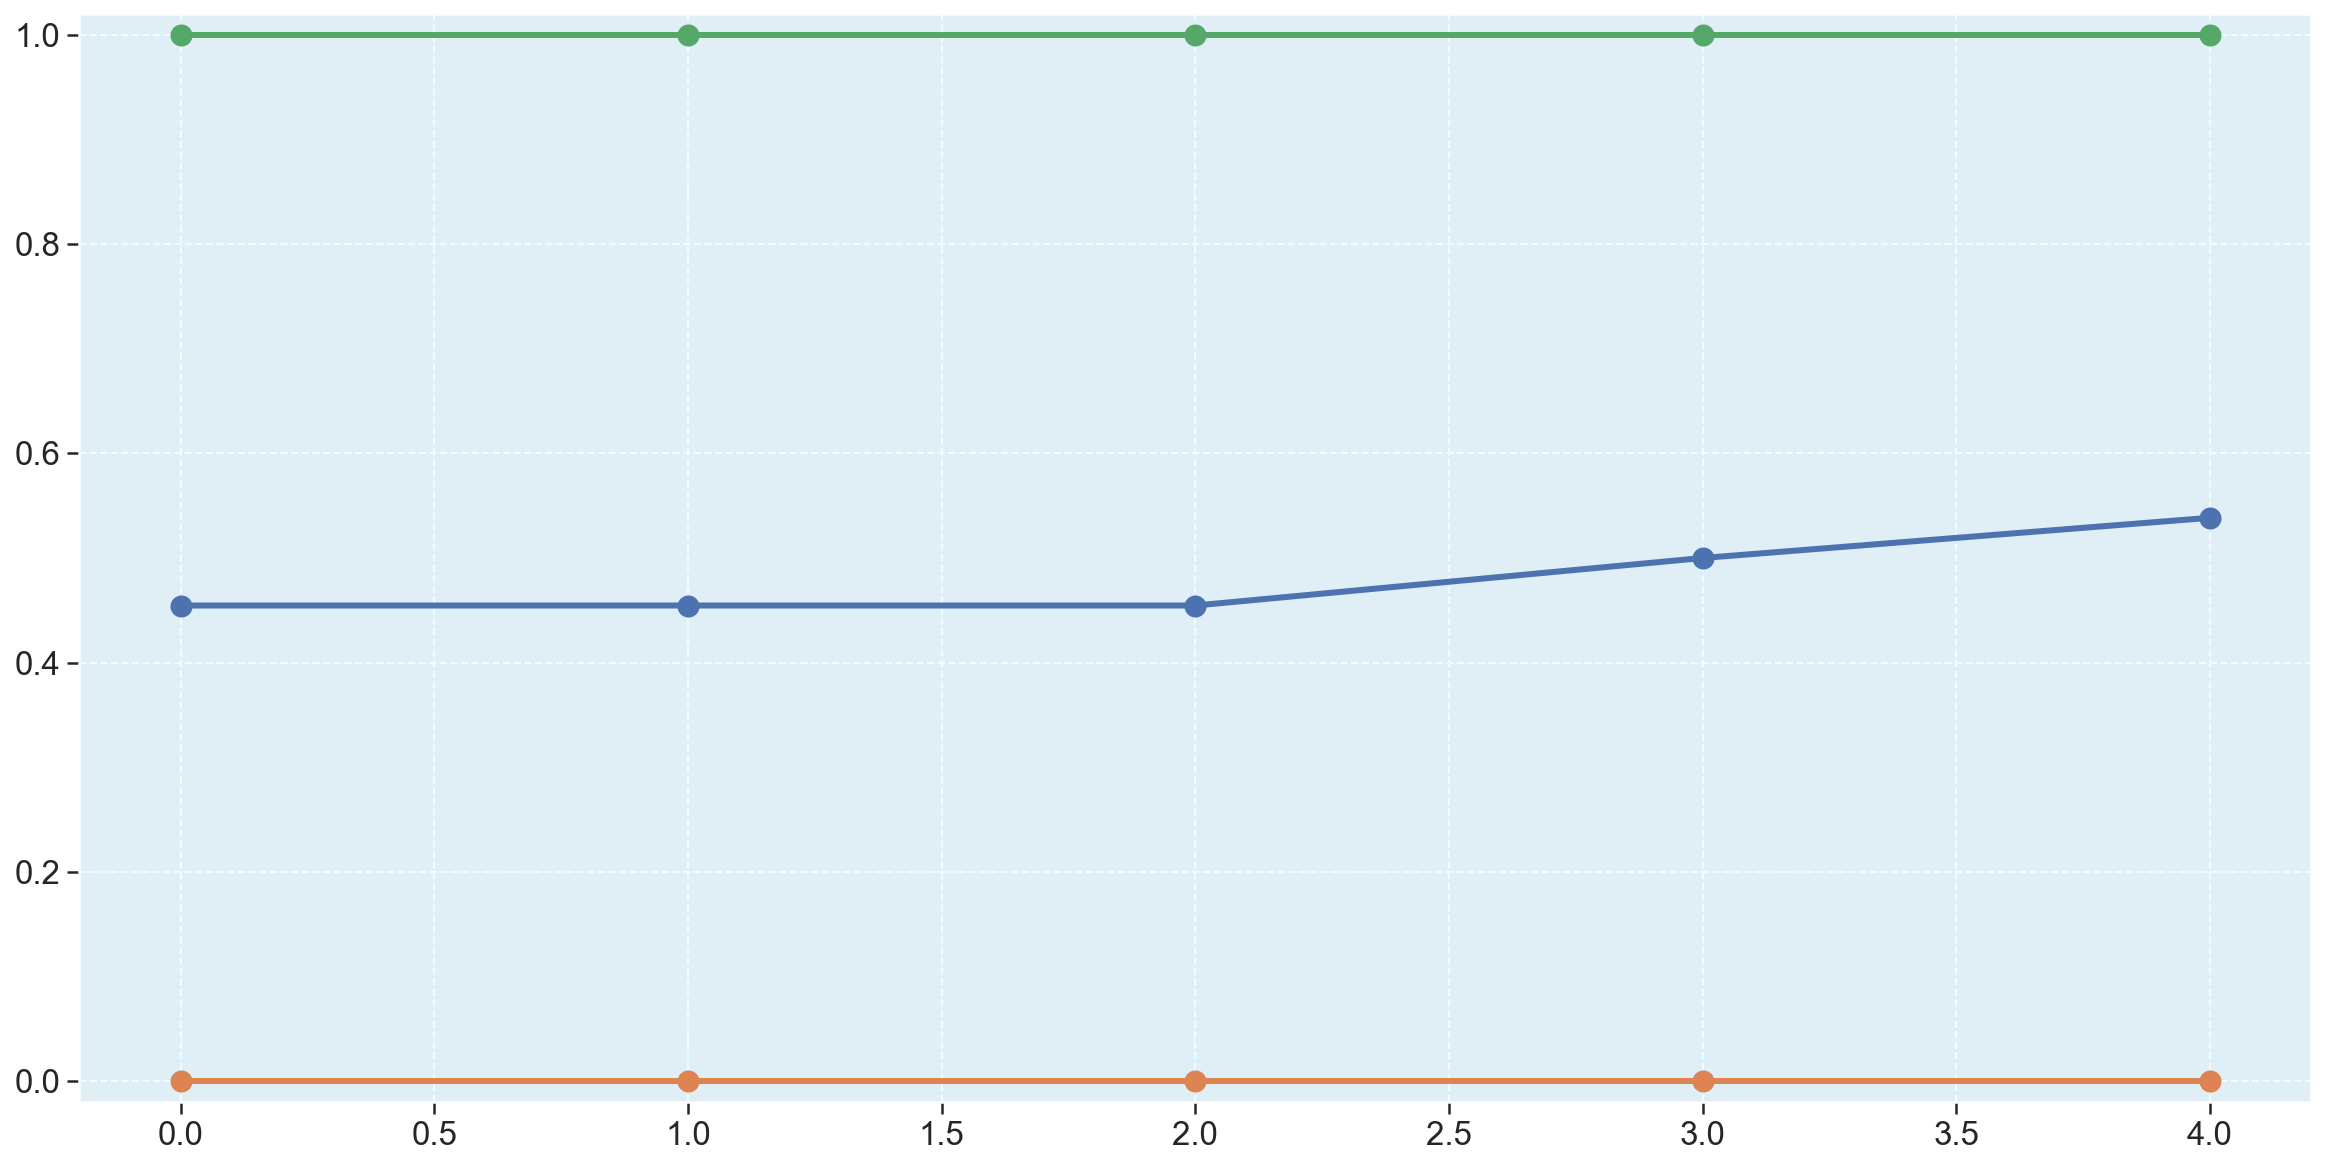

In [204]:
fig = plt.figure(figsize=(20, 10))

# Background color
plt.axhspan(-.02,1.02, color="#c9f9ff", alpha=0.3)

plt.plot(repository_metrics["Lend.it-gateway"]['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repository_metrics["Lend.it-gateway"]['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repository_metrics["Lend.it-gateway"]['m3'], linewidth=3, marker='o', markersize=10)

plt.ylim(-.02,1.02)

### Ponderação e Agregação na SubCaracterística

In [205]:
psc1 = 1
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

repository_metrics["Lend.it-user"]['asc1'] = ((repository_metrics["Lend.it-user"]['m1']*pm1)+
                                                                   (repository_metrics["Lend.it-user"]['m2']*pm2)+
                                                                   (repository_metrics["Lend.it-user"]['m3']*pm3)) * psc1

repository_metrics["Lend.it-request"]['asc1'] = ((repository_metrics["Lend.it-request"]['m1']*pm1)+
                                                                   (repository_metrics["Lend.it-request"]['m2']*pm2)+
                                                                   (repository_metrics["Lend.it-request"]['m3']*pm3)) * psc1

repository_metrics["Lend.it-rating"]['asc1'] = ((repository_metrics["Lend.it-rating"]['m1']*pm1)+
                                                                   (repository_metrics["Lend.it-rating"]['m2']*pm2)+
                                                                   (repository_metrics["Lend.it-rating"]['m3']*pm3)) * psc1

repository_metrics["Lend.it-gateway"]['asc1'] = ((repository_metrics["Lend.it-gateway"]['m1']*pm1)+
                                                                   (repository_metrics["Lend.it-gateway"]['m2']*pm2)+
                                                                   (repository_metrics["Lend.it-gateway"]['m3']*pm3)) * psc1

(0.45, 0.7)

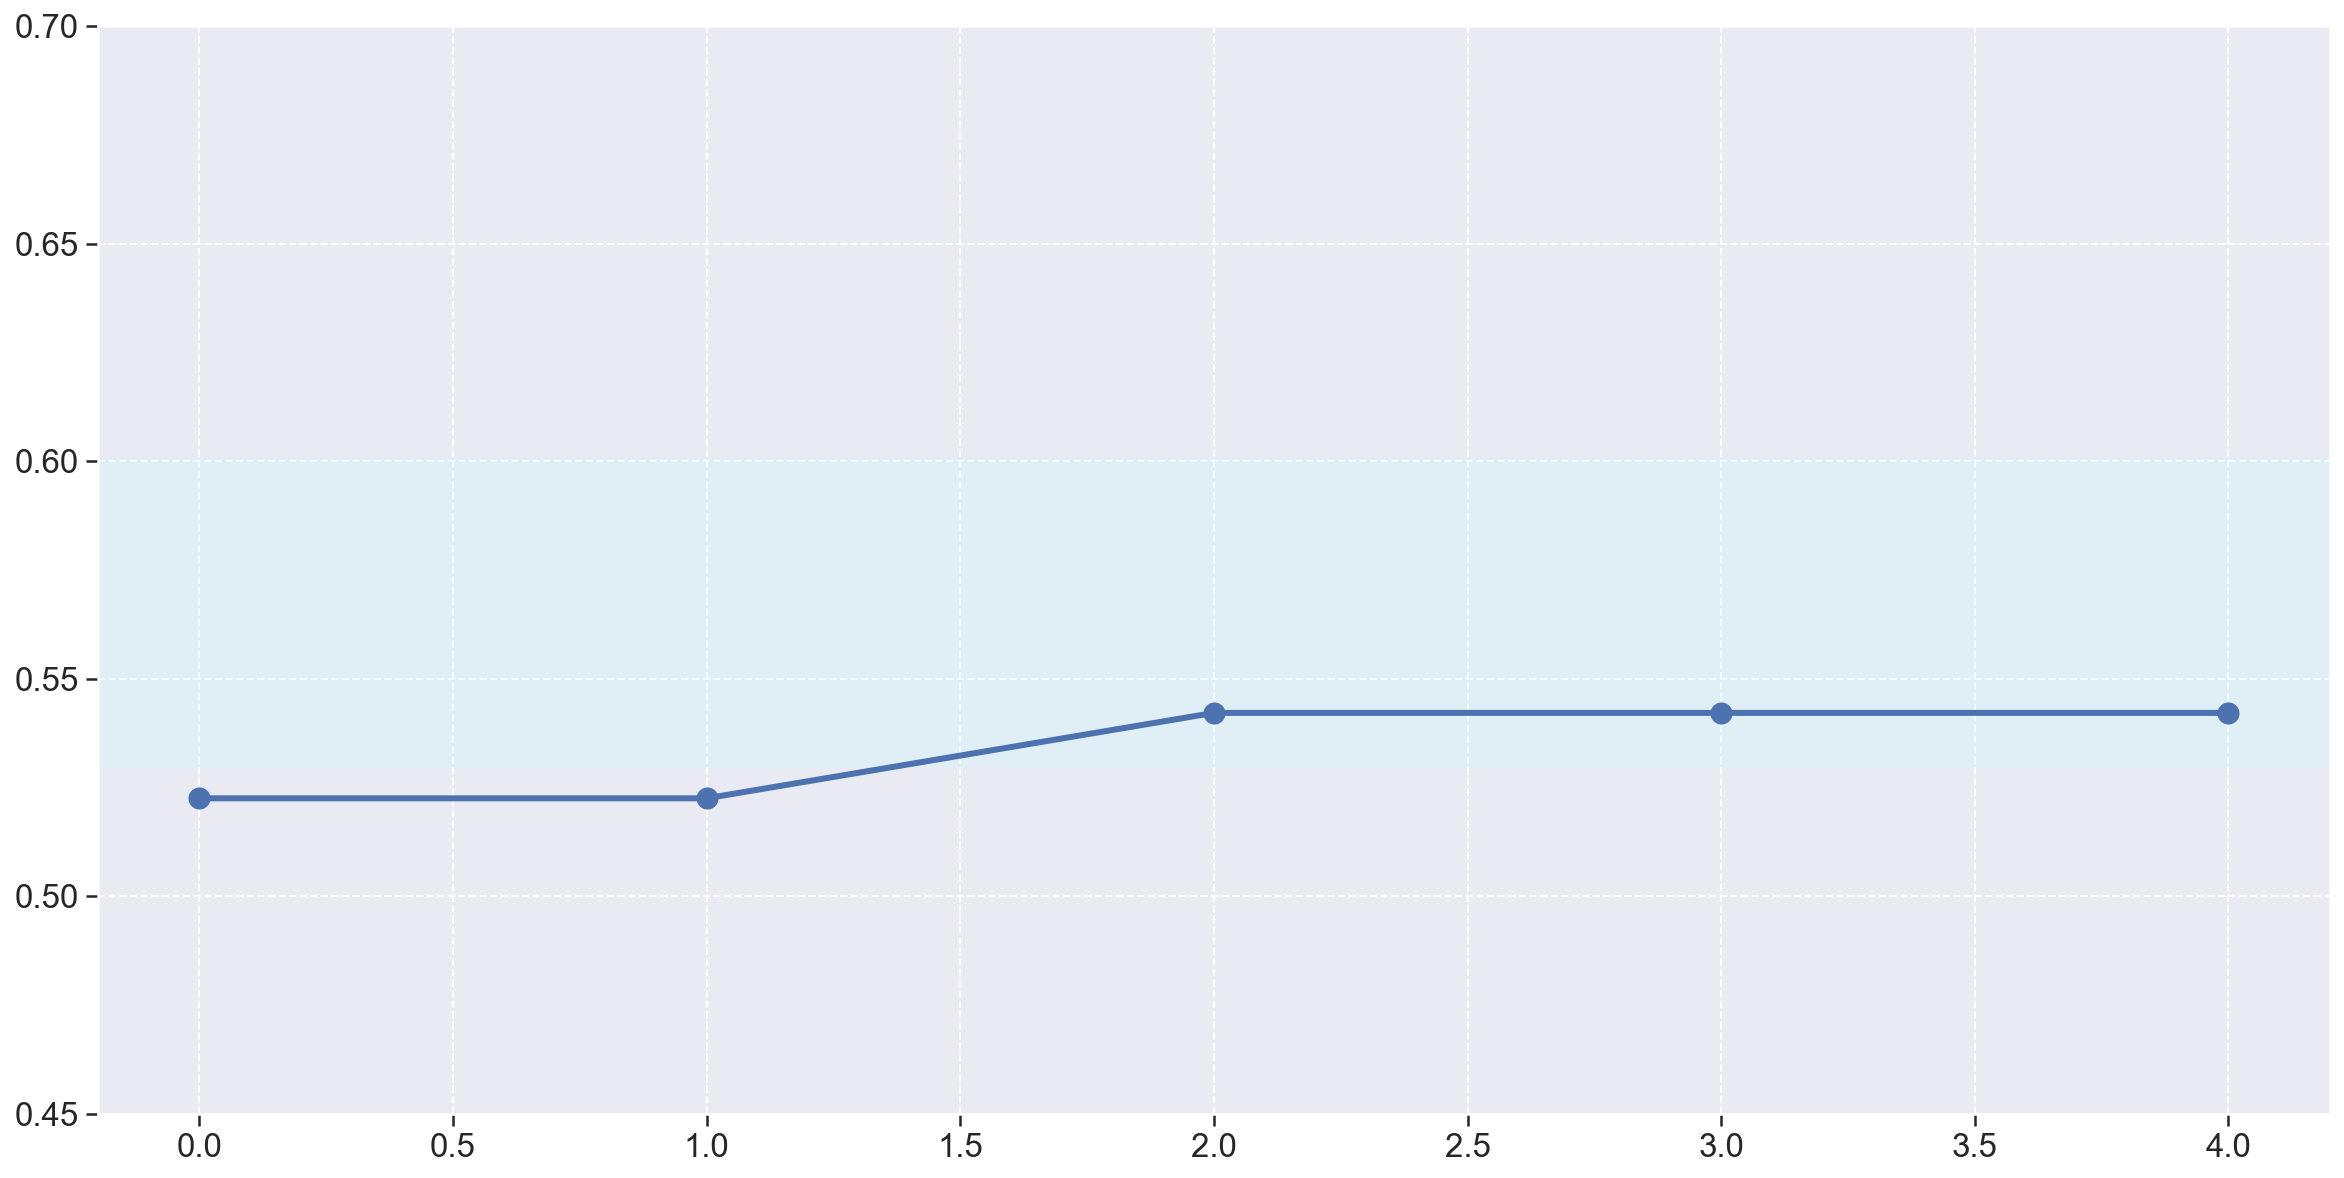

In [206]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repository_metrics["Lend.it-user"]['asc1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.53,.6, color="#c9f9ff", alpha=0.3)

plt.ylim(.45,.7)

(0.45, 0.7)

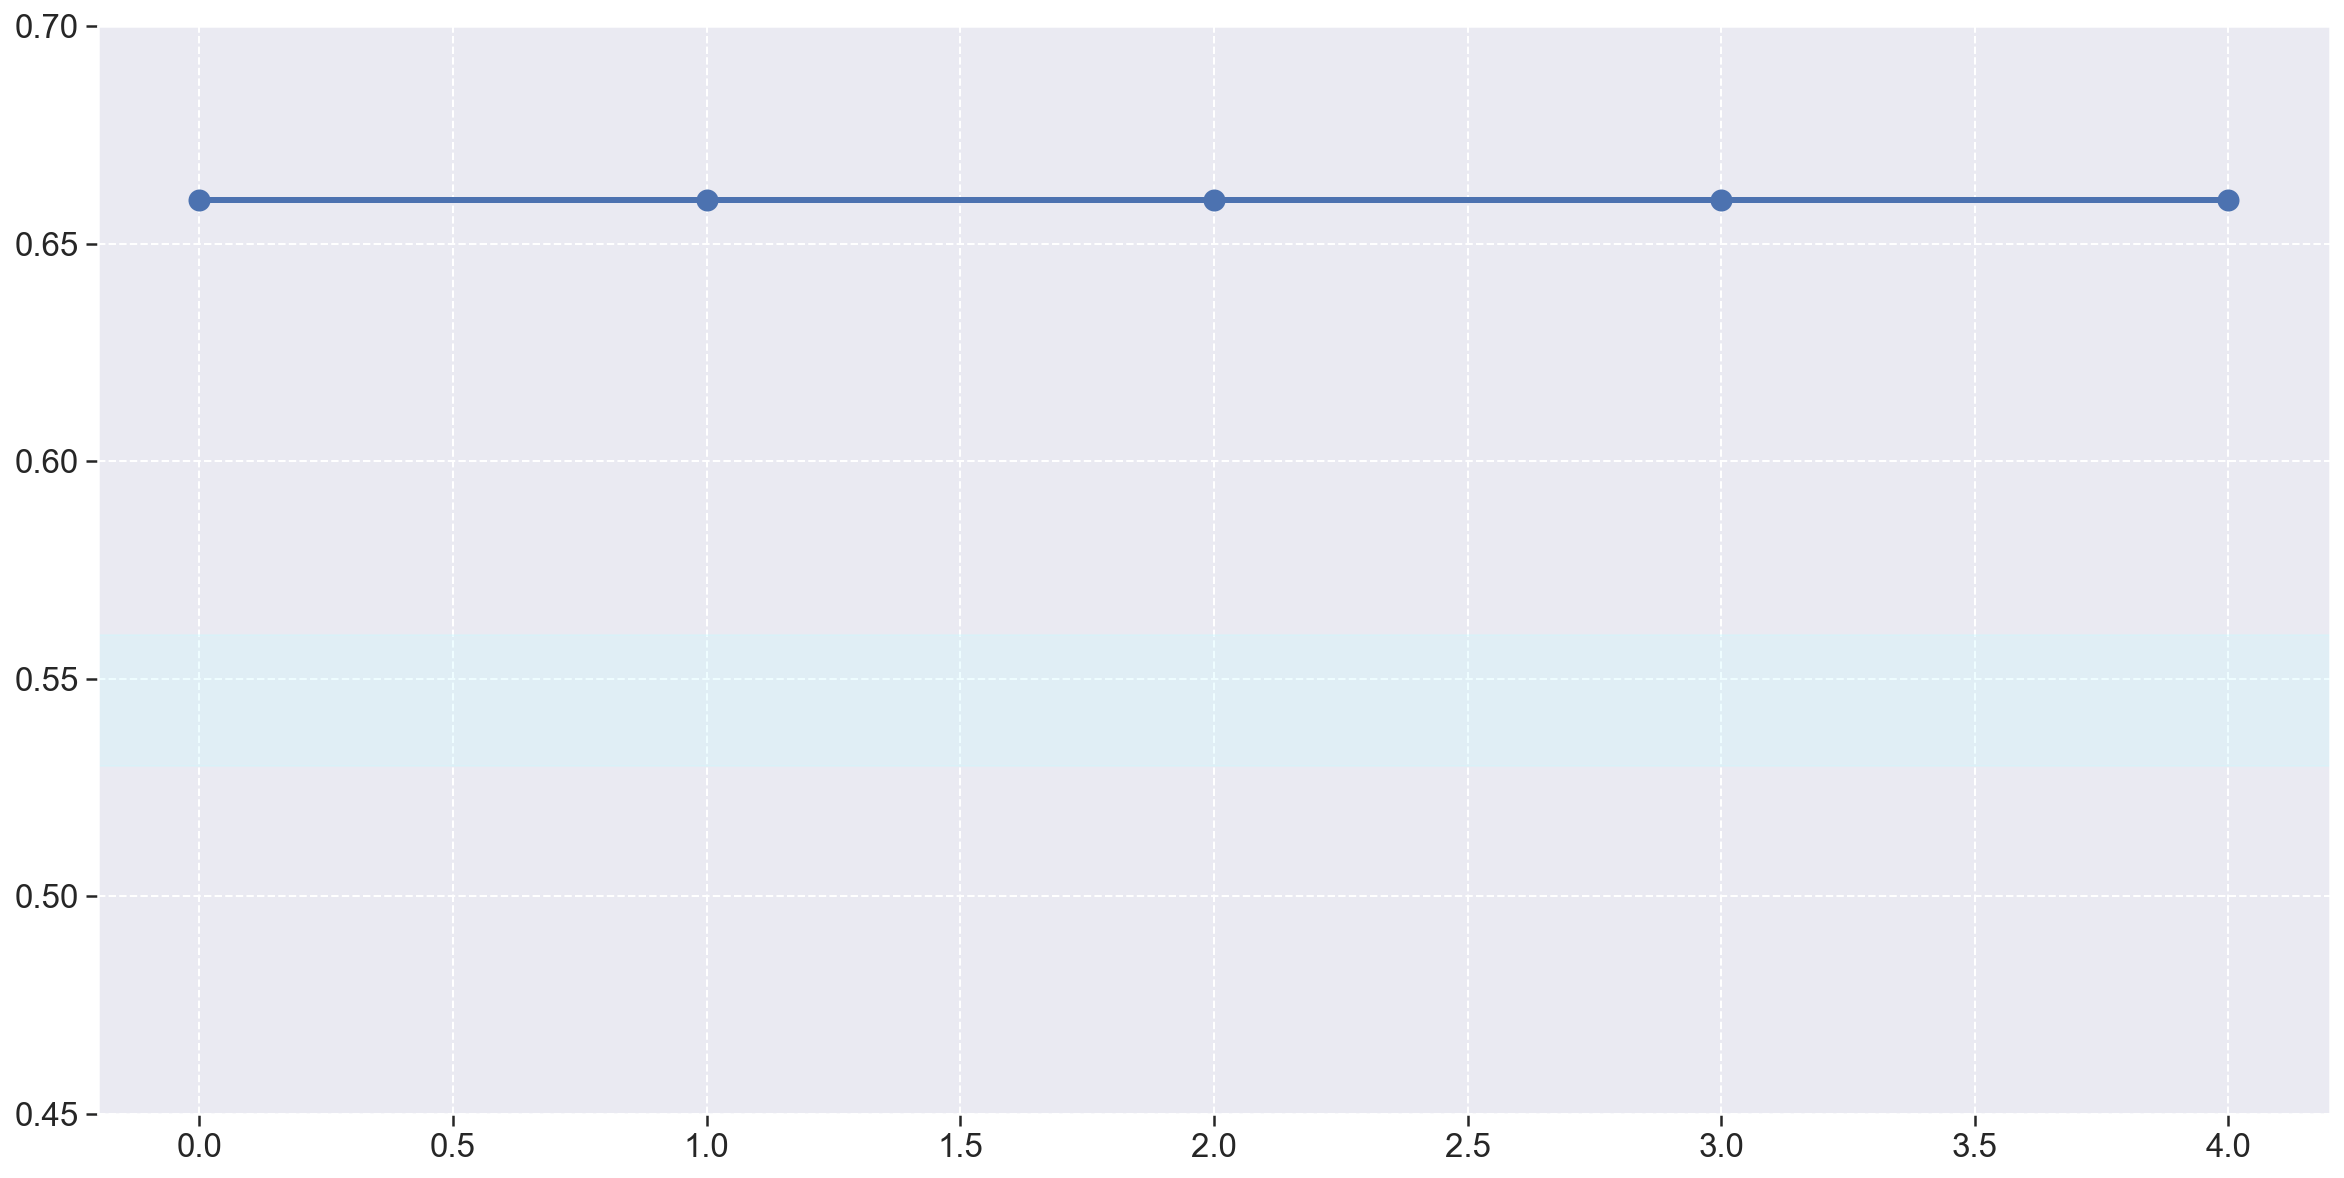

In [207]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repository_metrics["Lend.it-request"]['asc1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.53,.56, color="#c9f9ff", alpha=0.3)

plt.ylim(.45,.7)

(0.45, 0.7)

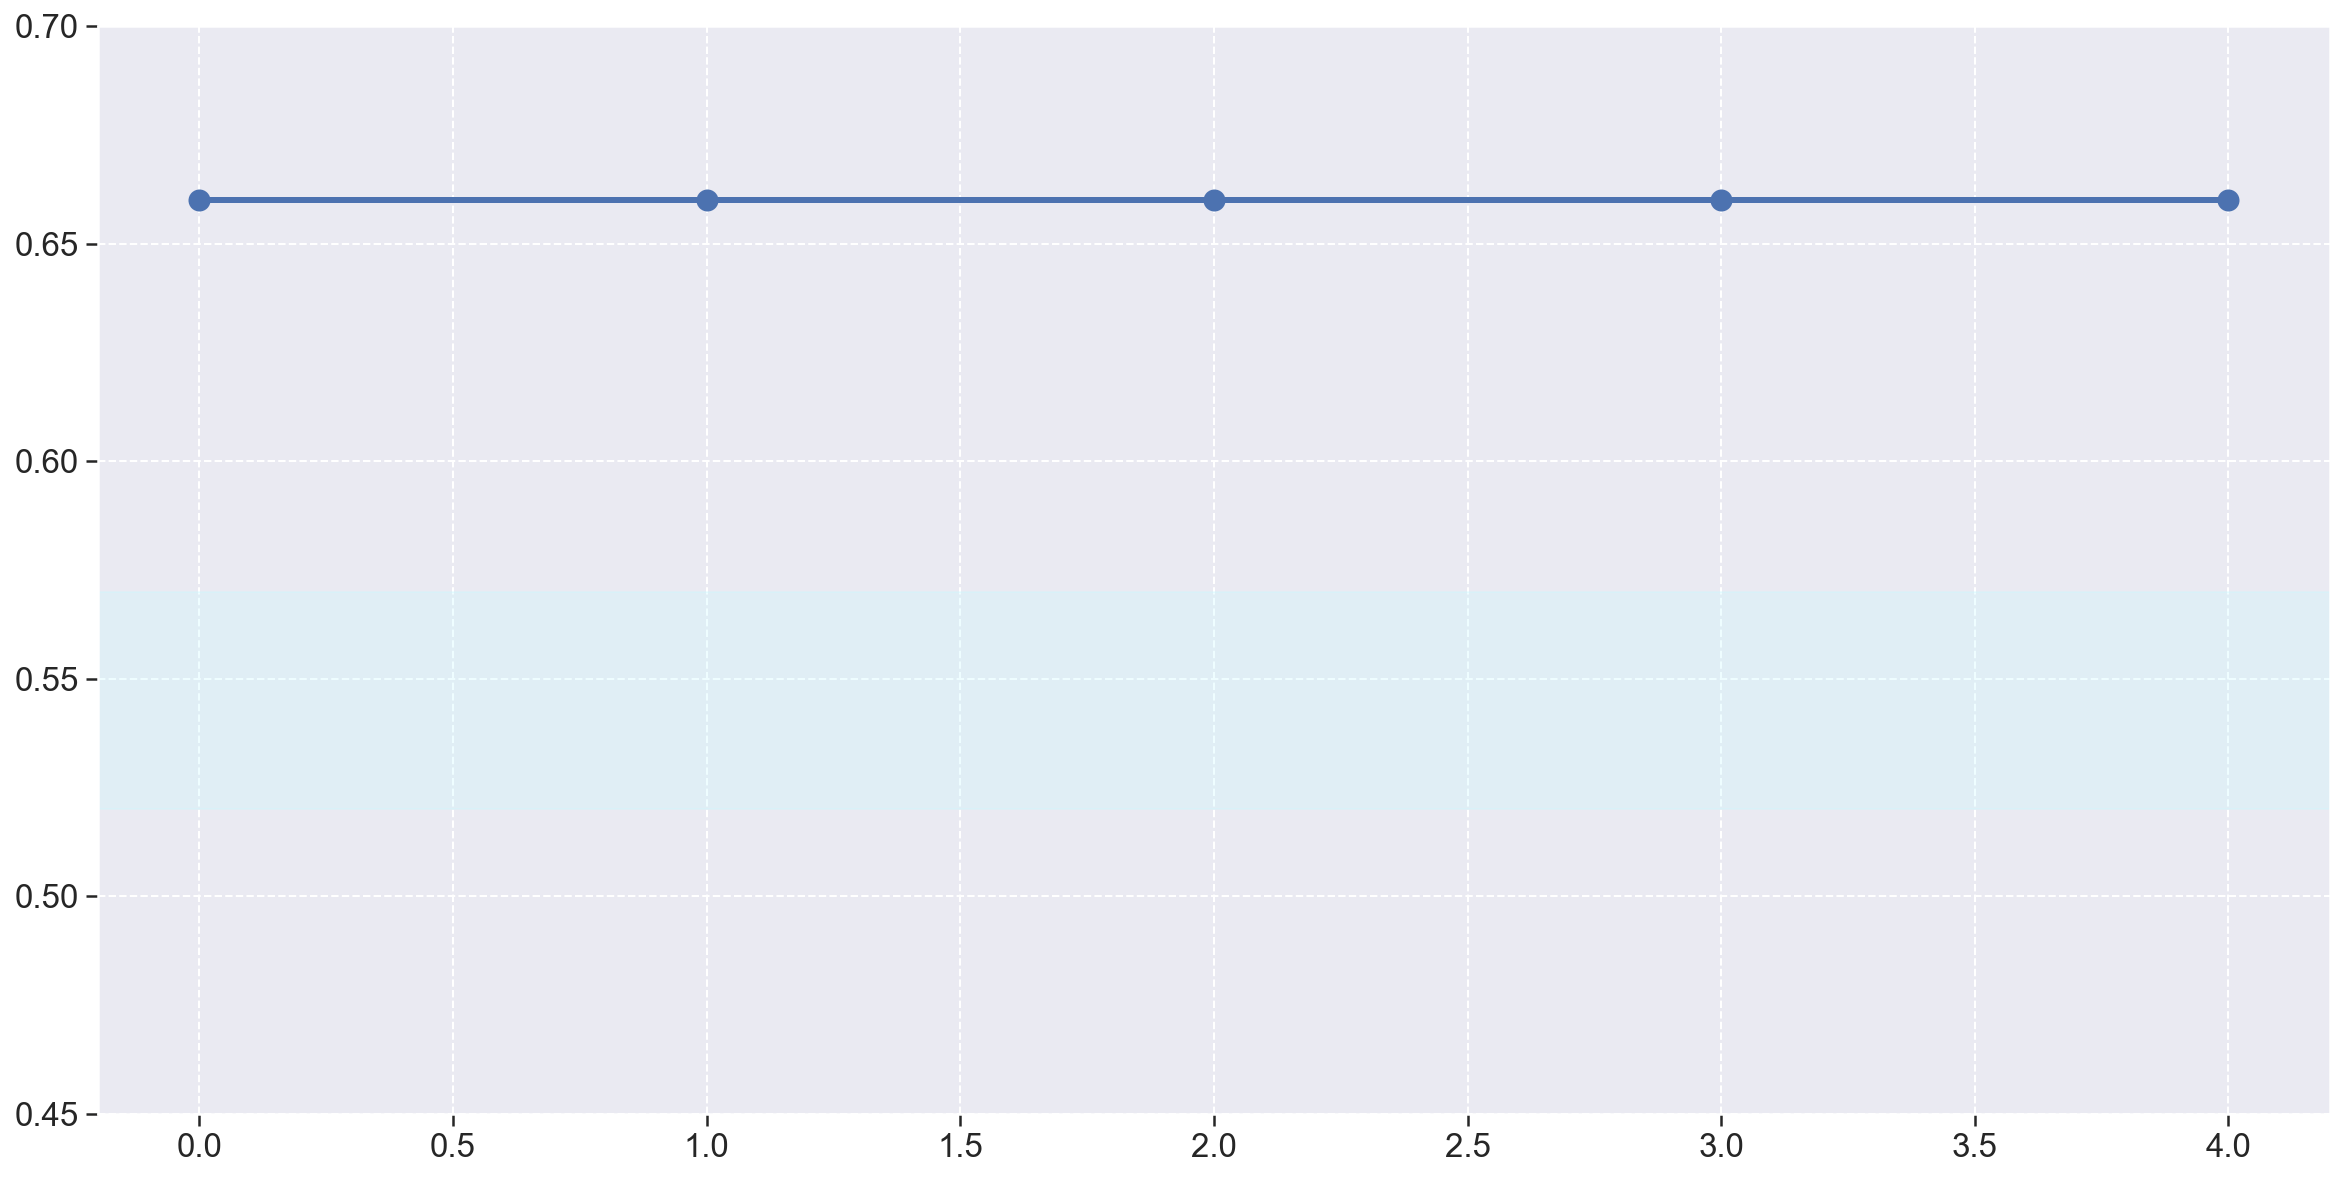

In [208]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repository_metrics["Lend.it-rating"]['asc1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.52,.57, color="#c9f9ff", alpha=0.3)

plt.ylim(.45,.7)

(0.45, 0.7)

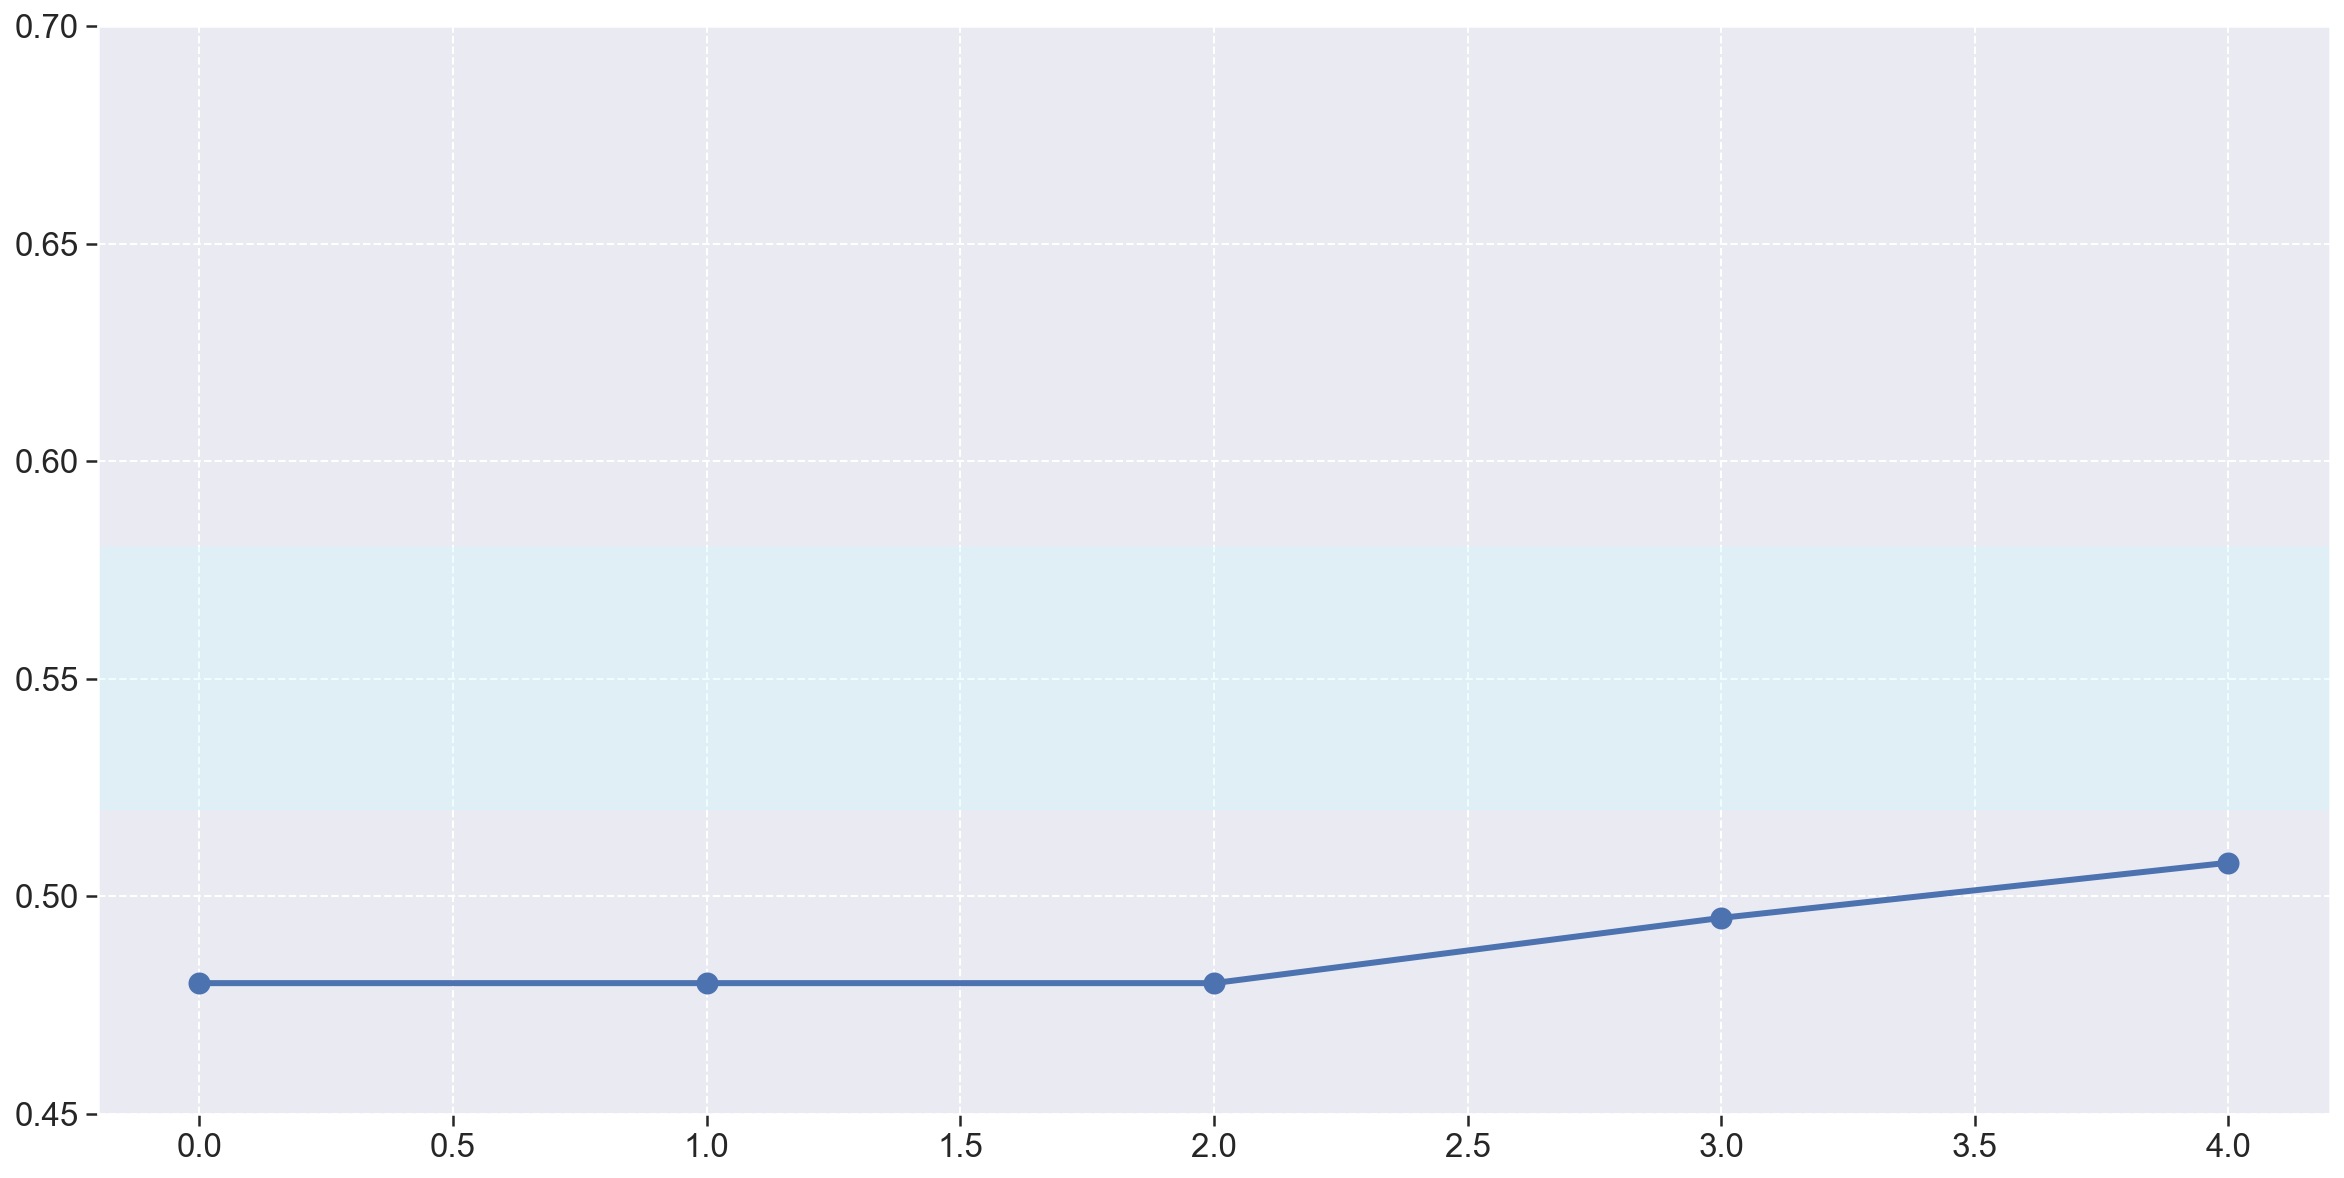

In [209]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repository_metrics["Lend.it-gateway"]['asc1'], linewidth=3, marker='o', markersize=10)

# Background color
plt.axhspan(.52,.58, color="#c9f9ff", alpha=0.3)

plt.ylim(.45,.7)

(0.45, 0.75)

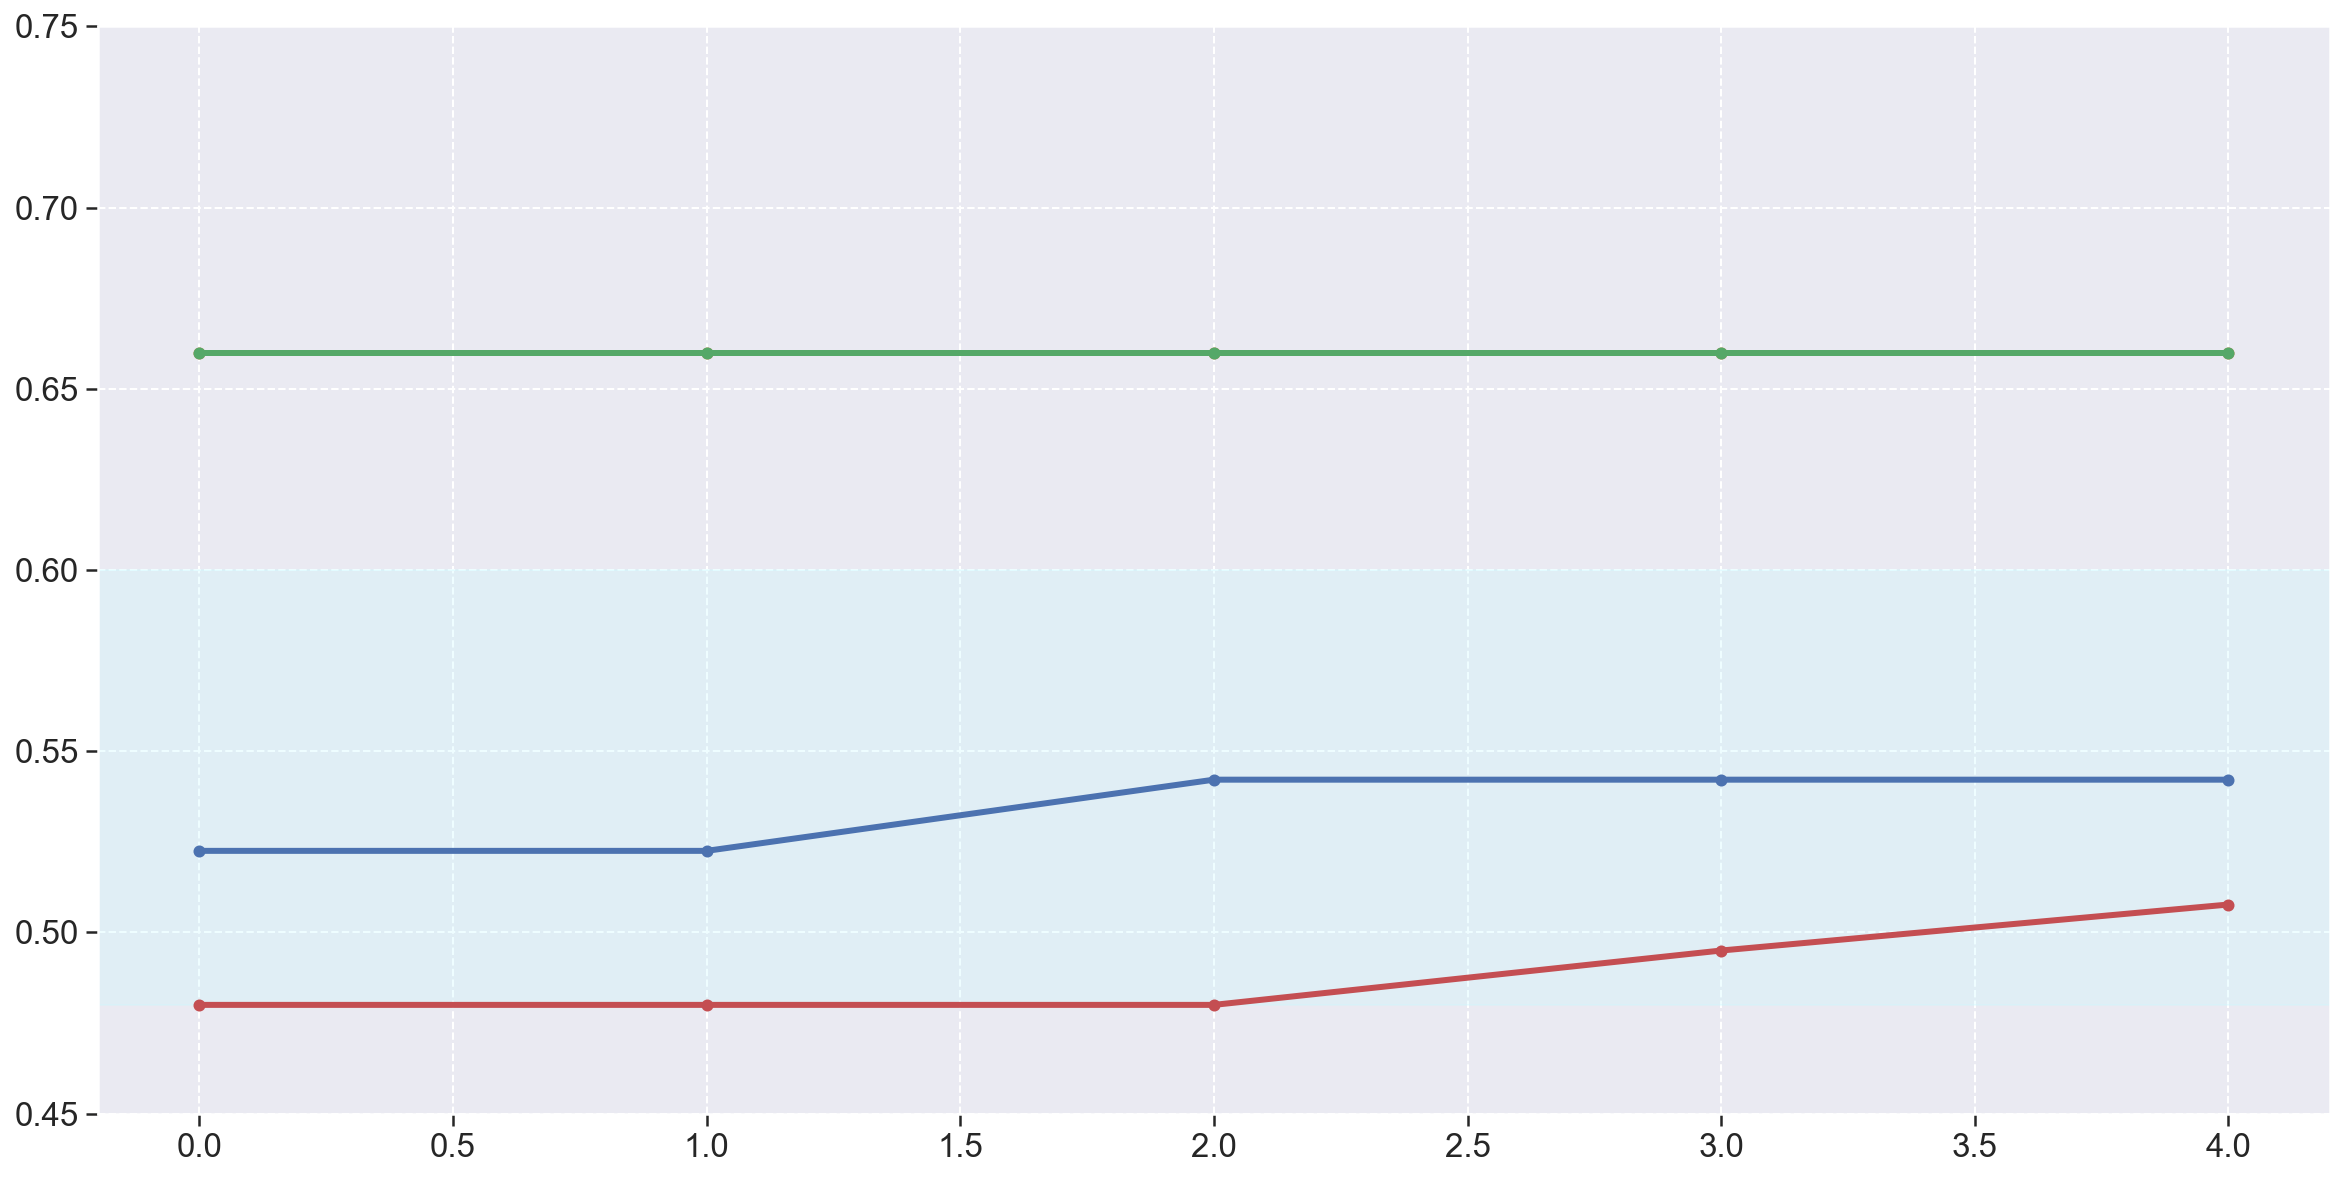

In [213]:
fig = plt.figure(figsize=(20, 10))


plt.plot(repository_metrics["Lend.it-user"]['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(repository_metrics["Lend.it-request"]['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(repository_metrics["Lend.it-rating"]['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(repository_metrics["Lend.it-gateway"]['asc1'], linewidth=3, marker='o', markersize=5)

# Background color
plt.axhspan(.48,.6, color="#c9f9ff", alpha=0.3)

plt.ylim(.45,.75)

In [216]:
metrics_df = pd.concat([repository_metrics["Lend.it-user"],
                        repository_metrics["Lend.it-request"],
                        repository_metrics["Lend.it-rating"],
                        repository_metrics["Lend.it-gateway"]], ignore_index=True)

In [217]:
metrics_df['ac1'] = metrics_df['asc1'] * 1
metrics_df['total'] = metrics_df['asc1'] * 1

In [218]:
metrics_df

,m1,m2,m3,repository,version,asc1,ac1,total
0,0.583333,0.000000,1.0,Lend.it-user,02-05-2021,0.522500,0.522500,0.522500
1,0.583333,0.000000,1.0,Lend.it-user,11-05-2021,0.522500,0.522500,0.522500
2,0.642857,0.000000,1.0,Lend.it-user,13-04-2021,0.542143,0.542143,0.542143
3,0.642857,0.000000,1.0,Lend.it-user,15-04-2021,0.542143,0.542143,0.542143
4,0.642857,0.000000,1.0,Lend.it-user,25-04-2021,0.542143,0.542143,0.542143
5,0.769231,0.230769,1.0,Lend.it-request,02-05-2021,0.660000,0.660000,0.660000
6,0.769231,0.230769,1.0,Lend.it-request,11-05-2021,0.660000,0.660000,0.660000
7,0.800000,0.200000,1.0,Lend.it-request,13-04-2021,0.660000,0.660000,0.660000
8,0.800000,0.200000,1.0,Lend.it-request,15-04-2021,0.660000,0.660000,0.660000
9,0.800000,0.200000,1.0,Lend.it-request,25-04-2021,0.660000,0.660000,0.660000


In [219]:
metrics_df.to_excel('data/fga-eps-mds-2020-2-data/lend-it/qrapids-lend-it-dataset-23-03-2021-24-05-2021-xlsx.xlsx', index = False)
metrics_df.to_csv('data/fga-eps-mds-2020-2-data/lend-it/qrapids-lend-it-dataset-23-03-2021-24-05-2021-csv.csv', header=False, index = False)